In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import timm
import torch
import torch as th
import torch.nn as nn
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from horama import maco, plot_maco
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms as T
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from circuit_toolkit.CNN_scorers import TorchScorer
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset

In [3]:
from neural_regress.regress_lib import sweep_regressors, perform_regression_sweeplayer_RidgeCV, perform_regression_sweeplayer, record_features
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch, LinearLayer_from_sklearn
from core.data_utils import load_neural_data, load_from_hdf5, load_neural_trial_resp_tensor, create_response_tensor, parse_image_fullpaths
from core.model_load_utils import load_model_transform

### Set up paths for data loading

In [4]:
"vvs-accentuate-day1_normalize_red_20241212-20241220.h5" # day 1 neural data
"vvs_accentuate_day3_normalize_red_20250123-20250126.hdf5" # day 3 neural data 
"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Stimuli/results_12-01-2025" # generated accentuated stimuli  

stimuli_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Stimuli"
ephys_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Ephys_Data"

datapath_day1 = join(ephys_root, "vvs-accentuate-day1_normalize_red_20241212-20241220.h5")
datapath_day3 = join(ephys_root, "vvs_accentuate_day3_normalize_red_20250123-20250126.hdf5")

imgdir_shared = join(stimuli_root, "shared1000")
imgdir_day1 = join(stimuli_root, "stimuli_pilot_20241119/results")
imgdir_day3 = join(stimuli_root, "results_12-01-2025")

In [5]:
# data_fulldict_day1 = load_from_hdf5(datapath_day1,)
# data_fulldict_day3 = load_from_hdf5(datapath_day3,)
subject_id1 = "red_20241212-20241220"
subject_id3 = "red_20250123-20250126"
data_dict_day1 = load_neural_data(datapath_day1, subject_id1, None)
data_dict_day3 = load_neural_data(datapath_day3, subject_id3, None)

In [6]:
data_dict_day1["image_fps"] = parse_image_fullpaths(data_dict_day1["stimulus_names"], [imgdir_shared, imgdir_day1])
data_dict_day3["image_fps"] = parse_image_fullpaths(data_dict_day3["stimulus_names"], [imgdir_shared, imgdir_day3])

All stimulus files were found
All stimulus files were found


### Model loading

In [7]:
encoding_root = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs"
encoding_dir = join(encoding_root, "red_20241212-20241220")

In [35]:
subject_id = "red_20241212-20241220"
model_name = "resnet50"
layer_name = ".layer4.Bottleneck1"
dimred_str = "pca1000"
regressor = "MultiTaskLassoCV"
meta_path = f"{subject_id}_{model_name}_meta_{layer_name}_{dimred_str}_{regressor}.pkl"
readout_path = f"{subject_id}_{model_name}_readout_{layer_name}_{dimred_str}_{regressor}.pth"
Xtransform_path = f"{subject_id}_{model_name}_Xtfmer_{layer_name}_{dimred_str}_{regressor}.pkl"

In [40]:
def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None


def get_population_predictor(subject_id="red_20241212-20241220",
                            model_name="resnet50",
                            layer_name=".layer4.Bottleneck1",
                            dimred_str="pca1000",
                            regressor="MultiTaskLassoCV", device="cuda"):
    """Create a function that predicts neural population responses for images.
    
    Args:
        subject_id (str): ID of the subject
        modelname (str): Name of the model to use (e.g. "resnet50_robust") 
        layer_name (str): Name of layer to extract features from
        device (str): Device to run model on ("cuda" or "cpu")
        
    Returns:
        function: A function that takes images as input and returns predicted population responses
    """
    # Construct paths
    
    model_root = f"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs/red_20241212-20241220"
    meta_path = join(model_root, f"{subject_id}_{model_name}_meta_{layer_name}_{dimred_str}_{regressor}.pkl")
    readout_path = join(model_root, f"{subject_id}_{model_name}_readout_{layer_name}_{dimred_str}_{regressor}.pth")
    Xtransform_path = join(model_root, f"{subject_id}_{model_name}_Xtfmer_{layer_name}_{dimred_str}_{regressor}.pkl")
    key = (f'{layer_name}_{dimred_str}', regressor)
    # readout_path = join(base_path, f"{subject_id}_{modelname}_sweep_regressors_readout_RidgeCV_{key[0]}.pth")
    # Xtransform_path = join(base_path, f"{subject_id}_{modelname}_sweep_regressors_Xtfmer_RidgeCV_{key[0]}.pkl")
    
    # Load model and set up feature extraction
    model, transforms_pipeline = load_model_transform(model_name, device=device)
    model = model.eval().to(device)
    model.requires_grad_(False)
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    fetcher.record(layer_name, ingraph=True, store_device=device)

    # Load readout layer
    state_dict = th.load(readout_path)
    readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).to(device)
    readout.load_state_dict(state_dict)
    
    # Load PCA transform
    pca = pkl.load(open(Xtransform_path, "rb"))
    Xtransform = PCA_torch(pca, device=device)

    def predict_population_response(images):
        """Predict neural population responses for input images.
        
        Args:
            images (torch.Tensor): Input images of shape (batch_size, 3, 224, 224)
            
        Returns:
            torch.Tensor: Predicted neural responses
        """
        model(images)
        feat_tsr = fetcher[layer_name]
        feat_vec = Xtransform(feat_tsr)
        return readout(feat_vec)

    check_gradient(predict_population_response)
    print("Gradient check passed!")
    return predict_population_response, model, transforms_pipeline, fetcher, Xtransform, readout

In [42]:
layer_name = ".layer4.Bottleneck1"
dimred_str = "pca1000"
pred_fn_RN50_Lasso, model_RNLasso, transforms_pipeline, _, _, _ = get_population_predictor(model_name="resnet50", regressor="MultiTaskLassoCV", )
pred_fn_RN50_Ridge, model_RNRidge, transforms_pipeline, _, _, _ = get_population_predictor(model_name="resnet50", regressor="RidgeCV", )
pred_fn_RN50robust_Lasso, model_RNrbstLasso, transforms_pipeline_rbst, _, _, _ = get_population_predictor(model_name="resnet50_robust", regressor="MultiTaskLassoCV", )
pred_fn_RN50robust_Ridge, model_RNrbstRidge, transforms_pipeline_rbst, _, _, _ = get_population_predictor(model_name="resnet50_robust", regressor="RidgeCV", )

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 64])
Gradient check passed!
torch.Size([1, 64])
Gradient check passed!


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([1, 64])
Gradient check passed!
torch.Size([1, 64])
Gradient check passed!


In [44]:
from circuit_toolkit.dataset_utils import ImagePathDataset, DataLoader

In [52]:
def get_prediction_responses(pred_fn, transforms_pipeline, image_fps, device="cuda", batch_size=100, num_workers=16):
    """
    Get the prediction responses for a set of images
    """
    dataset = ImagePathDataset(image_fps, transform=transforms_pipeline)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    pred_resp = []
    for batch in tqdm(dataloader):
        batch_img = batch[0].to(device)
        with th.no_grad():
            batch_resp = pred_fn(batch_img).cpu()
        pred_resp.append(batch_resp)
    return torch.cat(pred_resp, dim=0)

In [45]:
dataset_day1 = ImagePathDataset(data_dict_day1["image_fps"])
dataloader_day1 = DataLoader(dataset_day1, batch_size=100, shuffle=False, num_workers=10)
dataset_day3 = ImagePathDataset(data_dict_day3["image_fps"])
dataloader_day3 = DataLoader(dataset_day3, batch_size=100, shuffle=False, num_workers=10)

In [ ]:
population_pred_day3_RN50_Lasso = get_prediction_responses(pred_fn_RN50_Lasso, transforms_pipeline, data_dict_day3["image_fps"])
population_pred_day3_RN50_Ridge = get_prediction_responses(pred_fn_RN50_Ridge, transforms_pipeline, data_dict_day3["image_fps"])
population_pred_day3_RN50rbst_Lasso = get_prediction_responses(pred_fn_RN50robust_Lasso, transforms_pipeline_rbst, data_dict_day3["image_fps"])
population_pred_day3_RN50rbst_Ridge = get_prediction_responses(pred_fn_RN50robust_Ridge, transforms_pipeline_rbst, data_dict_day3["image_fps"])
# ~ 3min43s per run if loading from scratch

The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/35 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14994a833ac0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14994a833ac0>Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__

Exception ignored in: Traceback (most recent call last):
    <function _MultiProcessingDataLoaderIter.__del__ at 0x14994a833ac0>  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()

Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
      File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()    
    if w.is_alive():  File "/

The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/35 [00:00<?, ?it/s]

The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/35 [00:00<?, ?it/s]

The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/35 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14994a833ac0>
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14994a833ac0>
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/n/home12/binxuwang/.cond

In [54]:
population_pred_day1_RN50_Lasso = get_prediction_responses(pred_fn_RN50_Lasso, transforms_pipeline, data_dict_day1["image_fps"])
population_pred_day1_RN50_Ridge = get_prediction_responses(pred_fn_RN50_Ridge, transforms_pipeline, data_dict_day1["image_fps"])
population_pred_day1_RN50rbst_Lasso = get_prediction_responses(pred_fn_RN50robust_Lasso, transforms_pipeline_rbst, data_dict_day1["image_fps"])
population_pred_day1_RN50rbst_Ridge = get_prediction_responses(pred_fn_RN50robust_Ridge, transforms_pipeline_rbst, data_dict_day1["image_fps"])

The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/11 [00:00<?, ?it/s]

The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/11 [00:00<?, ?it/s]

The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/11 [00:00<?, ?it/s]

The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _ConnectionBase.__del__ at 0x14994ab384c0>
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 177, in close
    reader_close()
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/

In [56]:
data_dict_day3["resp_mat"].shape

(3420, 64)

In [59]:
encoding_dir = encoding_root

In [60]:

pkl.dump({
    "image_fps": data_dict_day3["image_fps"],
    "stimulus_names": data_dict_day3["stimulus_names"],
    "resp_mat": data_dict_day3["resp_mat"],
    "population_pred_day3_RN50_L4B1_Lasso": population_pred_day3_RN50_Lasso,
    "population_pred_day3_RN50_L4B1_Ridge": population_pred_day3_RN50_Ridge,
    "population_pred_day3_RN50rbst_L4B1_Lasso": population_pred_day3_RN50rbst_Lasso,
    "population_pred_day3_RN50rbst_L4B1_Ridge": population_pred_day3_RN50rbst_Ridge,
}, open(join(encoding_dir, f"population_resp_pred_{subject_id3}_RN50_RN50rbst_L4B1_Lasso_Ridge.pkl"), "wb"))

pkl.dump({
    "image_fps": data_dict_day1["image_fps"],
    "stimulus_names": data_dict_day1["stimulus_names"],
    "resp_mat": data_dict_day1["resp_mat"],
    "population_pred_day1_RN50_L4B1_Lasso": population_pred_day1_RN50_Lasso,
    "population_pred_day1_RN50_L4B1_Ridge": population_pred_day1_RN50_Ridge,
    "population_pred_day1_RN50rbst_L4B1_Lasso": population_pred_day1_RN50rbst_Lasso,
    "population_pred_day1_RN50rbst_L4B1_Ridge": population_pred_day1_RN50rbst_Ridge,
}, open(join(encoding_dir, f"population_resp_pred_{subject_id1}_RN50_RN50rbst_L4B1_Lasso_Ridge.pkl"), "wb"))

### use xarray to validate the responses

In [7]:
import xarray as xr

In [66]:

# Create coordinates dictionary
coords = {
    'stimulus': (['stimulus'], data_dict_day3["stimulus_names"]),
    'image_path': (['stimulus'], data_dict_day3["image_fps"]),
    'unit': (['unit'], range(data_dict_day3["resp_mat"].shape[1]))
}

# Create data dictionary with all response arrays
data_vars = {
    'neural_response': (['stimulus', 'unit'], data_dict_day3["resp_mat"]),
    'RN50_Lasso': (['stimulus', 'unit'], population_pred_day3_RN50_Lasso),
    'RN50_Ridge': (['stimulus', 'unit'], population_pred_day3_RN50_Ridge), 
    'RN50rbst_Lasso': (['stimulus', 'unit'], population_pred_day3_RN50rbst_Lasso),
    'RN50rbst_Ridge': (['stimulus', 'unit'], population_pred_day3_RN50rbst_Ridge)
}
# Create xarray Dataset
ds3 = xr.Dataset(data_vars=data_vars, coords=coords)
# Save dataset
ds3.to_netcdf(join(encoding_dir, f"population_resp_pred_{subject_id3}_RN50_RN50rbst_L4B1_Lasso_Ridge.nc"))

In [67]:
# do the same for day1
coords_day1 = {
    'stimulus': (['stimulus'], data_dict_day1["stimulus_names"]),
    'image_path': (['stimulus'], data_dict_day1["image_fps"]),
    'unit': (['unit'], range(data_dict_day1["resp_mat"].shape[1]))
}
data_vars_day1 = {
    'neural_response': (['stimulus', 'unit'], data_dict_day1["resp_mat"]),
    'RN50_Lasso': (['stimulus', 'unit'], population_pred_day1_RN50_Lasso),
    'RN50_Ridge': (['stimulus', 'unit'], population_pred_day1_RN50_Ridge), 
    'RN50rbst_Lasso': (['stimulus', 'unit'], population_pred_day1_RN50rbst_Lasso),
    'RN50rbst_Ridge': (['stimulus', 'unit'], population_pred_day1_RN50rbst_Ridge)
}
ds1 = xr.Dataset(data_vars=data_vars_day1, coords=coords_day1)
ds1.to_netcdf(join(encoding_dir, f"population_resp_pred_{subject_id1}_RN50_RN50rbst_L4B1_Lasso_Ridge.nc"))

<xarray.Dataset> Size: 8MB
Dimensions:          (stimulus: 3420, unit: 64)
Coordinates:
  * stimulus         (stimulus) <U107 1MB 'controversial_max_r50_MultiLassoCV...
    image_path       (stimulus) <U184 3MB ...
  * unit             (unit) int64 512B 0 1 2 3 4 5 6 7 ... 57 58 59 60 61 62 63
Data variables:
    neural_response  (stimulus, unit) float32 876kB ...
    RN50_Lasso       (stimulus, unit) float32 876kB ...
    RN50_Ridge       (stimulus, unit) float32 876kB ...
    RN50rbst_Lasso   (stimulus, unit) float32 876kB ...
    RN50rbst_Ridge   (stimulus, unit) float32 876kB ...

In [9]:
encoding_root = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs"
encoding_dir = join(encoding_root, "red_20241212-20241220")
ds1 = xr.open_dataset(join(encoding_dir, f"population_resp_pred_{subject_id1}_RN50_RN50rbst_L4B1_Lasso_Ridge.nc"))
ds3 = xr.open_dataset(join(encoding_dir, f"population_resp_pred_{subject_id3}_RN50_RN50rbst_L4B1_Lasso_Ridge.nc"))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


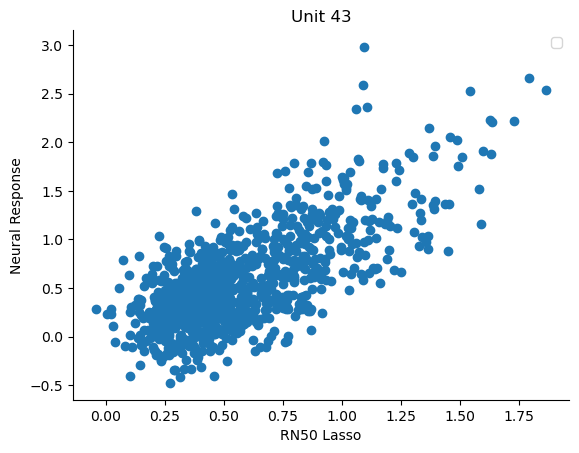

In [17]:
unit_id = 43
plt.scatter(ds1.RN50_Lasso[:, unit_id], ds1.neural_response[:, unit_id])
plt.xlabel("RN50 Lasso")
plt.ylabel("Neural Response")
plt.title(f"Unit {unit_id}")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


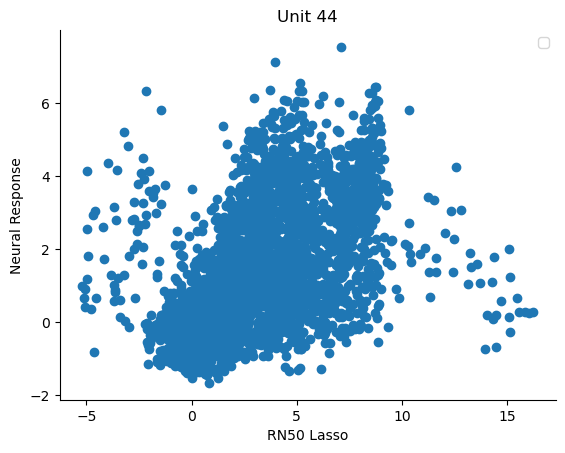

In [20]:
unit_id = 44
plt.scatter(ds3.RN50_Lasso[:, unit_id], ds3.neural_response[:, unit_id])
plt.xlabel("RN50 Lasso")
plt.ylabel("Neural Response")
plt.title(f"Unit {unit_id}")
plt.legend()
plt.show()

### Stimuli name parsing

In [7]:
import xarray as xr
encoding_root = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs"
encoding_dir = join(encoding_root, "red_20241212-20241220")
ds1 = xr.open_dataset(join(encoding_dir, f"population_resp_pred_{subject_id1}_RN50_RN50rbst_L4B1_Lasso_Ridge.nc"))
ds3 = xr.open_dataset(join(encoding_dir, f"population_resp_pred_{subject_id3}_RN50_RN50rbst_L4B1_Lasso_Ridge.nc"))

In [8]:
stimulus_d3 = pd.DataFrame(ds3.stimulus.values, columns=['stimulus'])

In [9]:
# Extract information using regex for all stimuli
import re
import pandas as pd

pattern = r'(?P<model>resnet50|robust_resnet50)_(?P<method>MultiLassoCV|RidgeCV)_unit_(?P<unit>\d+)_img_(?P<img>\d+)_level_(?P<level>[-\d.]+)_score_(?P<score>[-\d.]+)\.png'
# Initialize empty list to store matches
matches = []
# Go through all stimuli
for stim in stimulus_d3.stimulus.values:
    match = re.match(pattern, stim)
    if match:
        info = match.groupdict()
        info["stimulus"] = stim
        info["accentuated"] = True
        matches.append(info)
    else:
        # For non-matching stimuli (like NSD), add None values
        matches.append({
            "stimulus": stim,
            "accentuated": False,
            'model': None,
            'method': None, 
            'unit': None,
            'img': None,
            'level': None,
            'score': None
        })

# Convert to DataFrame
stim_meta_df = pd.DataFrame(matches)
# Convert numeric columns
numeric_cols = ['level', 'score']
for col in numeric_cols:
    stim_meta_df[col] = pd.to_numeric(stim_meta_df[col], errors='coerce').astype(float)

# Convert unit and img to int where possible, keeping NaN values
numeric_cols = ['unit', 'img']
for col in numeric_cols:
    stim_meta_df[col] = pd.to_numeric(stim_meta_df[col], errors='coerce').astype('Int64') 
print("Extracted information for all stimuli:")
print(stim_meta_df.head())
print(f"\nTotal rows: {len(stim_meta_df)}")
stim_meta_df["is_nsd"] = stimulus_d3['stimulus'].str.contains('nsd')
stim_meta_df["is_controversial"] = stimulus_d3['stimulus'].str.contains('controversial')
# assert that there is no controversial or nsd in the accentuated stimuli
assert stim_meta_df.query('not (accentuated or is_controversial or is_nsd)').empty

Extracted information for all stimuli:
                                            stimulus  accentuated model  \
0  controversial_max_r50_MultiLassoCV_unit_15_img...        False  None   
1  controversial_max_r50_MultiLassoCV_unit_15_img...        False  None   
2  controversial_max_r50_MultiLassoCV_unit_15_img...        False  None   
3  controversial_max_r50_MultiLassoCV_unit_15_img...        False  None   
4  controversial_max_r50_MultiLassoCV_unit_15_img...        False  None   

  method  unit   img  level  score  
0   None  <NA>  <NA>    NaN    NaN  
1   None  <NA>  <NA>    NaN    NaN  
2   None  <NA>  <NA>    NaN    NaN  
3   None  <NA>  <NA>    NaN    NaN  
4   None  <NA>  <NA>    NaN    NaN  

Total rows: 3420


In [10]:
stim_meta_df.query("is_controversial").stimulus.unique()
# Pattern to match controversial image filenames
controversial_pattern = r'controversial_max_(?P<model>r50|robust)_(?P<method>MultiLassoCV)_unit_(?P<unit>\d+)_img_(?P<img>\d+)_srobust_(?P<score_robust>[-\d.]+)_sr50_(?P<score_r50>[-\d.]+)\.png'

# Initialize empty list to store matches
controversial_matches = []

# Go through controversial stimuli
controversial_stimuli = stim_meta_df.query("is_controversial").stimulus.values
for stim in controversial_stimuli:
    match = re.match(controversial_pattern, stim)
    if match:
        info = match.groupdict()
        info["stimulus"] = stim
        controversial_matches.append(info)
    else:
        print(f"No match found for controversial stimulus: {stim}")

# Convert to DataFrame
controversial_df = pd.DataFrame(controversial_matches)

# Convert numeric columns
numeric_cols = ['score_robust', 'score_r50',]
for col in numeric_cols:
    controversial_df[col] = pd.to_numeric(controversial_df[col], errors='coerce')
numeric_cols = ['unit', 'img']
for col in numeric_cols:
    controversial_df[col] = pd.to_numeric(controversial_df[col], errors='coerce').astype('Int64')

# Print first few rows to verify parsing
print("Extracted information from controversial stimuli:")
print(controversial_df.head())
print(f"\nTotal controversial stimuli parsed: {len(controversial_df)}")

Extracted information from controversial stimuli:
  model        method  unit  img  score_robust  score_r50  \
0   r50  MultiLassoCV    15    0     -0.394836  10.820349   
1   r50  MultiLassoCV    15    1     -0.322991  11.145054   
2   r50  MultiLassoCV    15    2     -0.555082  11.866060   
3   r50  MultiLassoCV    15    3     -0.861608  10.422665   
4   r50  MultiLassoCV    15    4     -0.915930   9.685411   

                                            stimulus  
0  controversial_max_r50_MultiLassoCV_unit_15_img...  
1  controversial_max_r50_MultiLassoCV_unit_15_img...  
2  controversial_max_r50_MultiLassoCV_unit_15_img...  
3  controversial_max_r50_MultiLassoCV_unit_15_img...  
4  controversial_max_r50_MultiLassoCV_unit_15_img...  

Total controversial stimuli parsed: 140


In [11]:
stim_contrv_meta_df = stim_meta_df.fillna(controversial_df).merge(controversial_df[["stimulus", "score_robust", "score_r50", ]], on="stimulus", how="outer")

In [12]:
stim_contrv_meta_df

stimulus  accentuated model  \
0     controversial_max_r50_MultiLassoCV_unit_15_img...        False   r50   
1     controversial_max_r50_MultiLassoCV_unit_15_img...        False   r50   
2     controversial_max_r50_MultiLassoCV_unit_15_img...        False   r50   
3     controversial_max_r50_MultiLassoCV_unit_15_img...        False   r50   
4     controversial_max_r50_MultiLassoCV_unit_15_img...        False   r50   
...                                                 ...          ...   ...   
3415                            shared0508_nsd38495.png        False   NaN   
3416                            shared0560_nsd42215.png        False   NaN   
3417                            shared0631_nsd46161.png        False   NaN   
3418                            shared0862_nsd62480.png        False   NaN   
3419                            shared0974_nsd70506.png        False   NaN   

            method  unit   img  level  score  is_nsd  is_controversial  \
0     MultiLassoCV    15     0    NaN    NaN   False              True   
1     MultiLassoCV    15     1    NaN    NaN   False              True   
2     MultiLassoCV    15     2    NaN    NaN   False              True   
3     MultiLassoCV    15     3    NaN    NaN   False              True   
4     MultiLassoCV    15     4    NaN    NaN   False              True   
...            ...   ...   ...    ...    ...     ...               ...   
3415           NaN  <NA>  <NA>    NaN    NaN    True             False   
3416           NaN  <NA>  <NA>    NaN    NaN    True             False   
3417           NaN  <NA>  <NA>    NaN    NaN    True             False   
3418           NaN  <NA>  <NA>    NaN    NaN    True             False   
3419           NaN  <NA>  <NA>    NaN    NaN    True             False   

      score_robust  score_r50  
0        -0.394836  10.820349  
1        -0.322991  11.145054  
2        -0.555082  11.866060  
3        -0.861608  10.422665  
4        -0.915930   9.685411  
...            ...        ...  
3415           NaN        NaN  
3416           NaN        NaN  
3417           NaN        NaN  
3418           NaN        NaN  
3419           NaN        NaN  

[3420 rows x 12 columns]

In [15]:
unit_acc_partdf = stim_meta_df.query('accentuated and model == "resnet50" and method == "MultiLassoCV" and unit == 15')
print(len(unit_acc_partdf.img.unique()))
print(len(unit_acc_partdf.level.unique()))
unit_acc_partdf

10
11


stimulus  accentuated     model  \
140  resnet50_MultiLassoCV_unit_15_img_0_level_-0.4...         True  resnet50   
141  resnet50_MultiLassoCV_unit_15_img_0_level_-1.2...         True  resnet50   
142  resnet50_MultiLassoCV_unit_15_img_0_level_-1.9...         True  resnet50   
143  resnet50_MultiLassoCV_unit_15_img_0_level_0.24...         True  resnet50   
144  resnet50_MultiLassoCV_unit_15_img_0_level_0.97...         True  resnet50   
..                                                 ...          ...       ...   
245  resnet50_MultiLassoCV_unit_15_img_9_level_2.45...         True  resnet50   
246  resnet50_MultiLassoCV_unit_15_img_9_level_3.18...         True  resnet50   
247  resnet50_MultiLassoCV_unit_15_img_9_level_3.92...         True  resnet50   
248  resnet50_MultiLassoCV_unit_15_img_9_level_4.65...         True  resnet50   
249  resnet50_MultiLassoCV_unit_15_img_9_level_5.39...         True  resnet50   

           method  unit  img     level     score  is_nsd  is_controversial  
140  MultiLassoCV    15    0 -0.492332 -0.483439   False             False  
141  MultiLassoCV    15    0 -1.228048 -1.221569   False             False  
142  MultiLassoCV    15    0 -1.963763 -1.954578   False             False  
143  MultiLassoCV    15    0  0.243383  0.234548   False             False  
144  MultiLassoCV    15    0  0.979098  0.973366   False             False  
..            ...   ...  ...       ...       ...     ...               ...  
245  MultiLassoCV    15    9  2.450529  2.443315   False             False  
246  MultiLassoCV    15    9  3.186244  3.176338   False             False  
247  MultiLassoCV    15    9  3.921959  3.916729   False             False  
248  MultiLassoCV    15    9  4.657675  4.647922   False             False  
249  MultiLassoCV    15    9  5.393390  5.333105   False             False  

[110 rows x 10 columns]

In [22]:
stim_contrv_meta_df.query("is_controversial")

stimulus  accentuated   model  \
0    controversial_max_r50_MultiLassoCV_unit_15_img...        False     r50   
1    controversial_max_r50_MultiLassoCV_unit_15_img...        False     r50   
2    controversial_max_r50_MultiLassoCV_unit_15_img...        False     r50   
3    controversial_max_r50_MultiLassoCV_unit_15_img...        False     r50   
4    controversial_max_r50_MultiLassoCV_unit_15_img...        False     r50   
..                                                 ...          ...     ...   
135  controversial_max_robust_MultiLassoCV_unit_9_i...        False  robust   
136  controversial_max_robust_MultiLassoCV_unit_9_i...        False  robust   
137  controversial_max_robust_MultiLassoCV_unit_9_i...        False  robust   
138  controversial_max_robust_MultiLassoCV_unit_9_i...        False  robust   
139  controversial_max_robust_MultiLassoCV_unit_9_i...        False  robust   

           method  unit  img  level  score  is_nsd  is_controversial  \
0    MultiLassoCV    15    0    NaN    NaN   False              True   
1    MultiLassoCV    15    1    NaN    NaN   False              True   
2    MultiLassoCV    15    2    NaN    NaN   False              True   
3    MultiLassoCV    15    3    NaN    NaN   False              True   
4    MultiLassoCV    15    4    NaN    NaN   False              True   
..            ...   ...  ...    ...    ...     ...               ...   
135  MultiLassoCV     9    5    NaN    NaN   False              True   
136  MultiLassoCV     9    6    NaN    NaN   False              True   
137  MultiLassoCV     9    7    NaN    NaN   False              True   
138  MultiLassoCV     9    8    NaN    NaN   False              True   
139  MultiLassoCV     9    9    NaN    NaN   False              True   

     score_robust  score_r50  
0       -0.394836  10.820349  
1       -0.322991  11.145054  
2       -0.555082  11.866060  
3       -0.861608  10.422665  
4       -0.915930   9.685411  
..            ...        ...  
135      7.210146  -6.689741  
136      6.248375  -7.551818  
137      8.703208  -6.569651  
138      9.503622  -6.913553  
139      4.949420  -3.300142  

[140 rows x 12 columns]

In [196]:
unit_acc_partdf = stim_contrv_meta_df.query('accentuated and model == "resnet50" and method == "RidgeCV" and unit == 1')

In [ ]:
def evaluate_r2_masked(true_arr, pred_arr, stim_mask, unit_mask):
    """
    Evaluate the R2 score for a given unit and stimulus mask
    """
    true_arr = true_arr[stim_mask, unit_mask]
    pred_arr = pred_arr[stim_mask, unit_mask]
    r2_arr = 1 - (true_arr - pred_arr) ** 2 / (true_arr - true_arr.mean(axis=0)) ** 2
    return r2_arr.mean()


unit_acc_partdf = stim_meta_df.query('accentuated and model == "resnet50" and method == "RidgeCV" and unit == 1')
# evaluate_r2_masked(ds3.neural_response, ds3.RN50_Ridge, unit_acc_partdf.index, 1)
evaluate_r2_masked(ds3.neural_response, ds3.RN50rbst_Ridge, unit_acc_partdf.index, 1)

<xarray.DataArray ()> Size: 8B
array(-24.88916884)
Coordinates:
    unit     int64 8B 1

### Plot scatter of unit response vs score


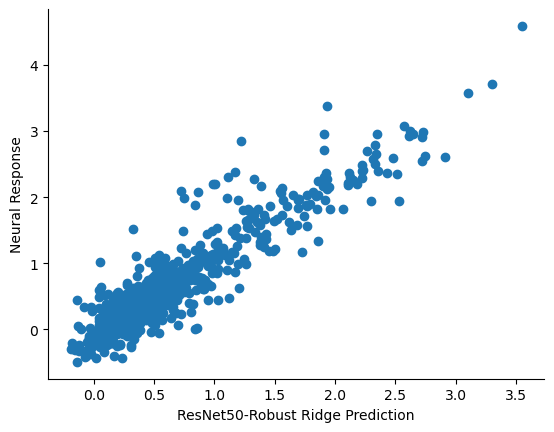

In [101]:
plt.scatter(ds1.RN50rbst_Ridge[:, 1], ds1.neural_response[:, 1], )#c=ds1.img)
plt.xlabel("ResNet50-Robust Ridge Prediction")
plt.ylabel("Neural Response")
plt.show()


In [102]:
def make_scatter_plot(x, y, c, xlabel, ylabel, title, **kwargs):
    """Helper function to create a standardized scatter plot"""
    plt.figure(figsize=(6,4))
    plt.scatter(x, y, c=c, 
               cmap='tab10', alpha=0.7, 
               marker='o', s=50,
               **kwargs)
    # print correlation coefficient
    corr_coeff = np.corrcoef(x, y)[0, 1]
    plt.xlabel(xlabel)
    plt.ylabel(ylabel) 
    plt.title(title+f"\nCorr {corr_coeff:.2f}")
    if c is not None:
        plt.colorbar(label="Image ID")
    plt.show()


/tmp/ipykernel_3677989/2848932732.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=c,


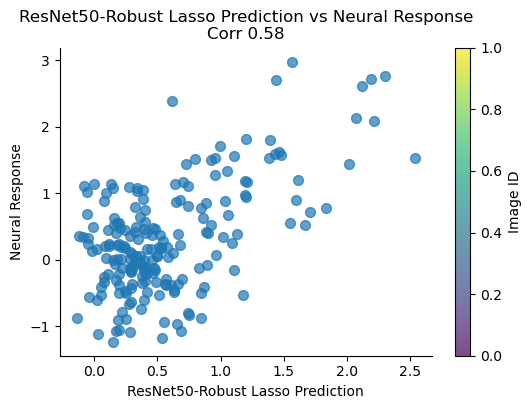

In [118]:
nsd_partdf = stim_meta_df.query('is_nsd')
make_scatter_plot(ds3.RN50_Lasso[nsd_partdf.index, 1], ds3.neural_response[nsd_partdf.index, 1], None,
                  "ResNet50-Robust Lasso Prediction", "Neural Response", "ResNet50-Robust Lasso Prediction vs Neural Response")

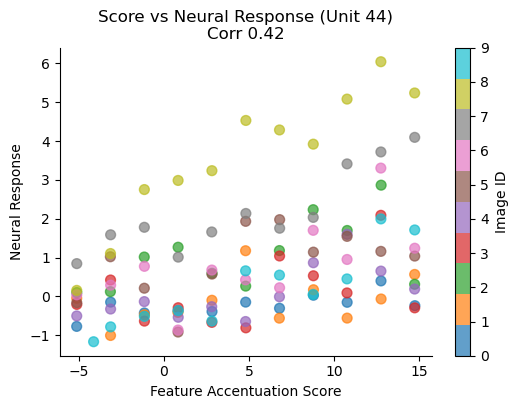

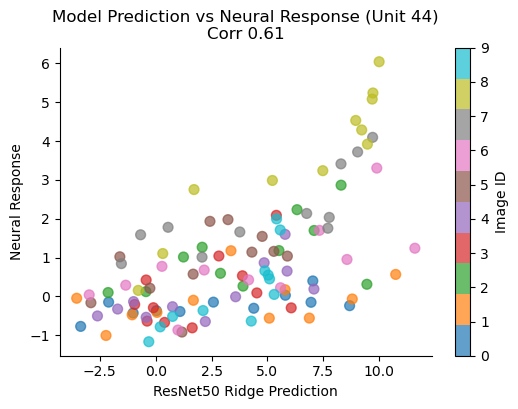

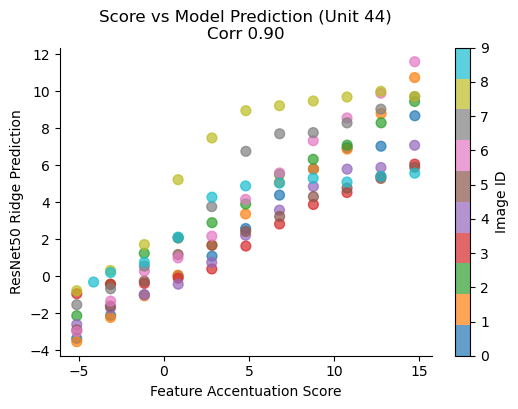

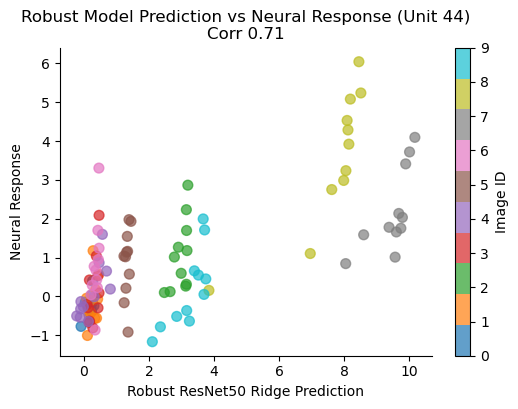

In [90]:
# Common parameters
unit_acc_partdf = stim_meta_df.query('accentuated and model == "resnet50" and method == "RidgeCV" and unit == 44')
unit_id = 44
idx = unit_acc_partdf.index
colors = unit_acc_partdf.img
# Generate all plots using the helper function
plot_configs = [
    # Score vs Neural Response
    {
        'x': unit_acc_partdf.score,
        'y': ds3.neural_response[idx, unit_id],
        'xlabel': "Feature Accentuation Score",
        'ylabel': "Neural Response",
        'title': f"Score vs Neural Response (Unit {unit_id})"
    },
    # Model Prediction vs Neural Response
    {
        'x': ds3.RN50_Ridge[idx, unit_id],
        'y': ds3.neural_response[idx, unit_id],
        'xlabel': "ResNet50 Ridge Prediction",
        'ylabel': "Neural Response",
        'title': f"Model Prediction vs Neural Response (Unit {unit_id})"
    },
    # Score vs Model Prediction
    {
        'x': unit_acc_partdf.score,
        'y': ds3.RN50_Ridge[idx, unit_id],
        'xlabel': "Feature Accentuation Score",
        'ylabel': "ResNet50 Ridge Prediction", 
        'title': f"Score vs Model Prediction (Unit {unit_id})"
    },
    # Robust Model vs Neural Response
    {
        'x': ds3.RN50rbst_Ridge[idx, unit_id],
        'y': ds3.neural_response[idx, unit_id],
        'xlabel': "Robust ResNet50 Ridge Prediction",
        'ylabel': "Neural Response", 
        'title': f"Robust Model Prediction vs Neural Response (Unit {unit_id})"
    }
]

for config in plot_configs:
    make_scatter_plot(c=colors, **config)

In [93]:
stim_meta_df.model.unique()

array([None, 'resnet50', 'robust_resnet50'], dtype=object)

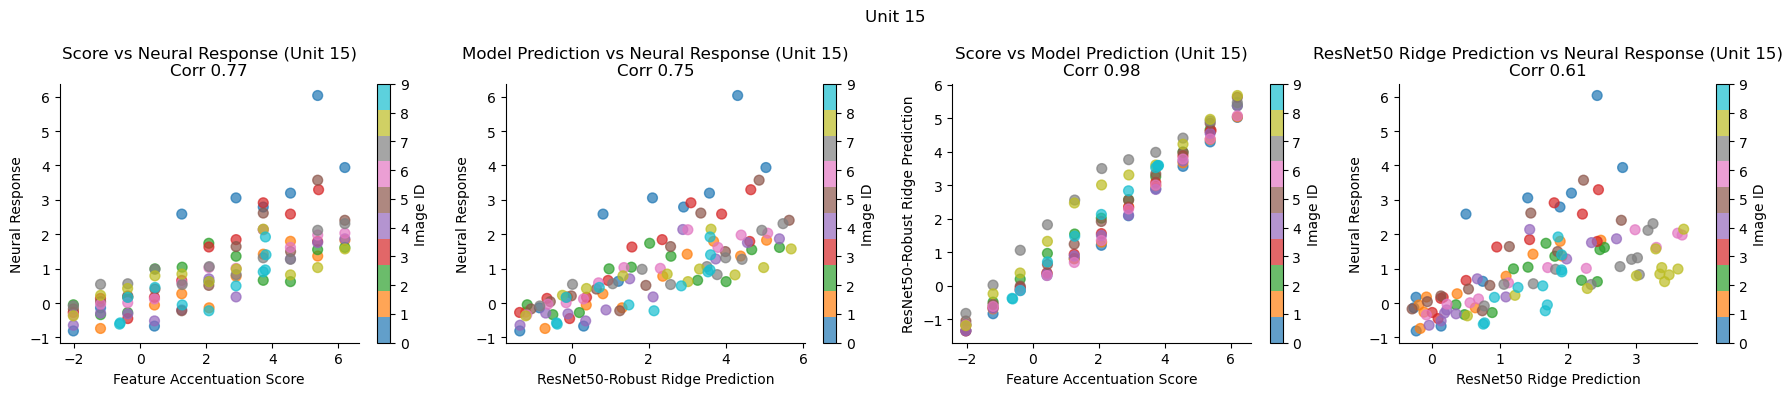

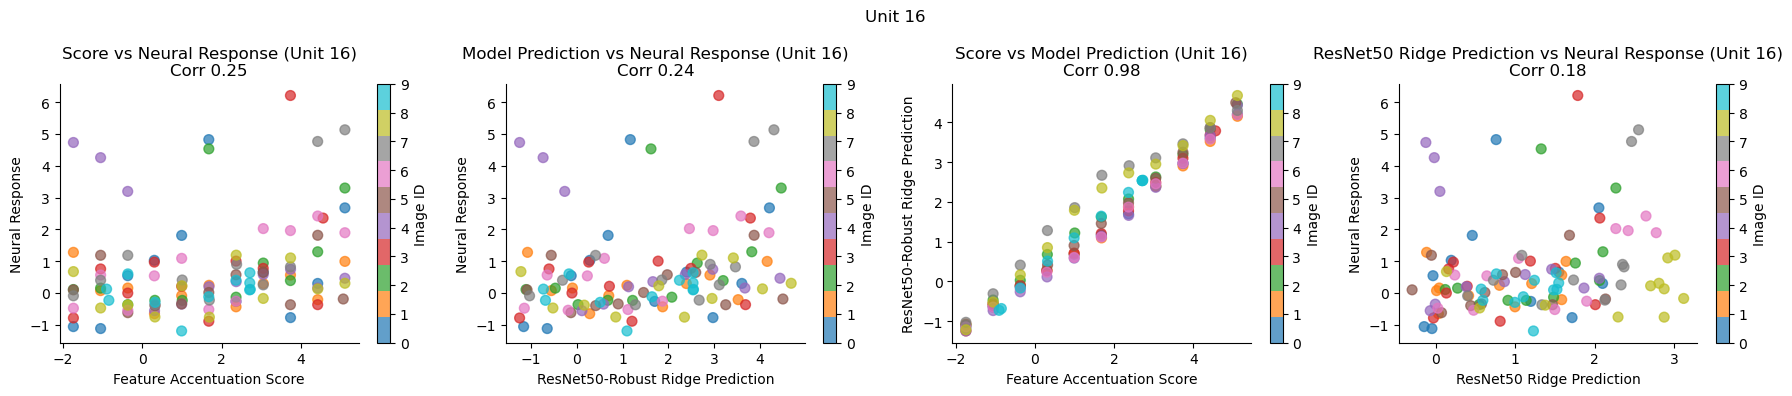

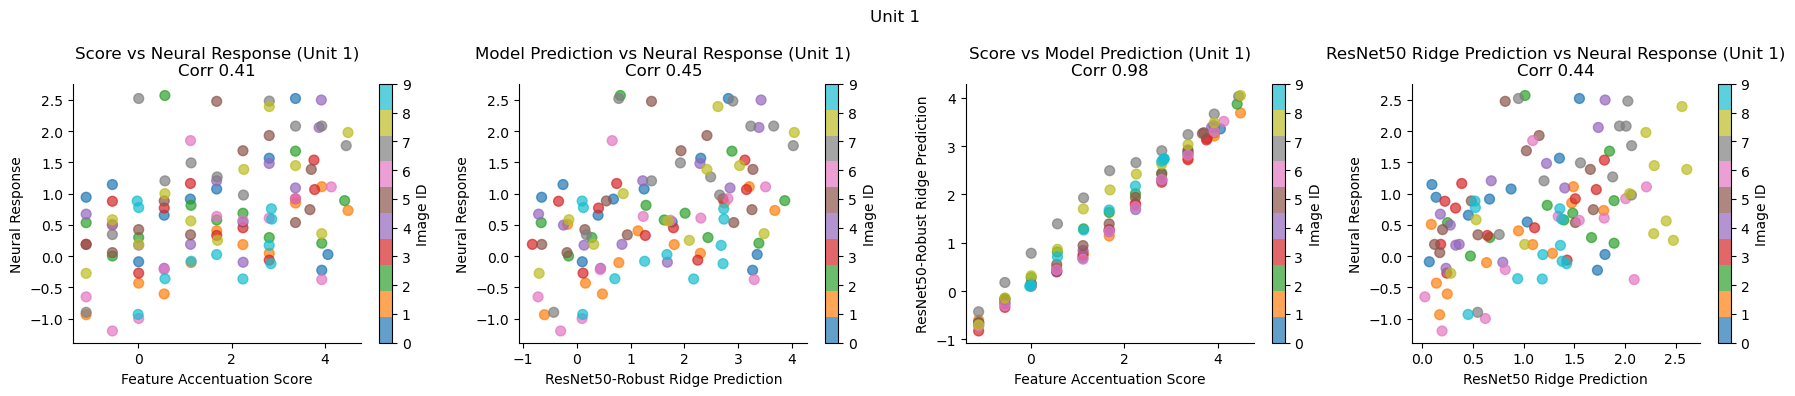

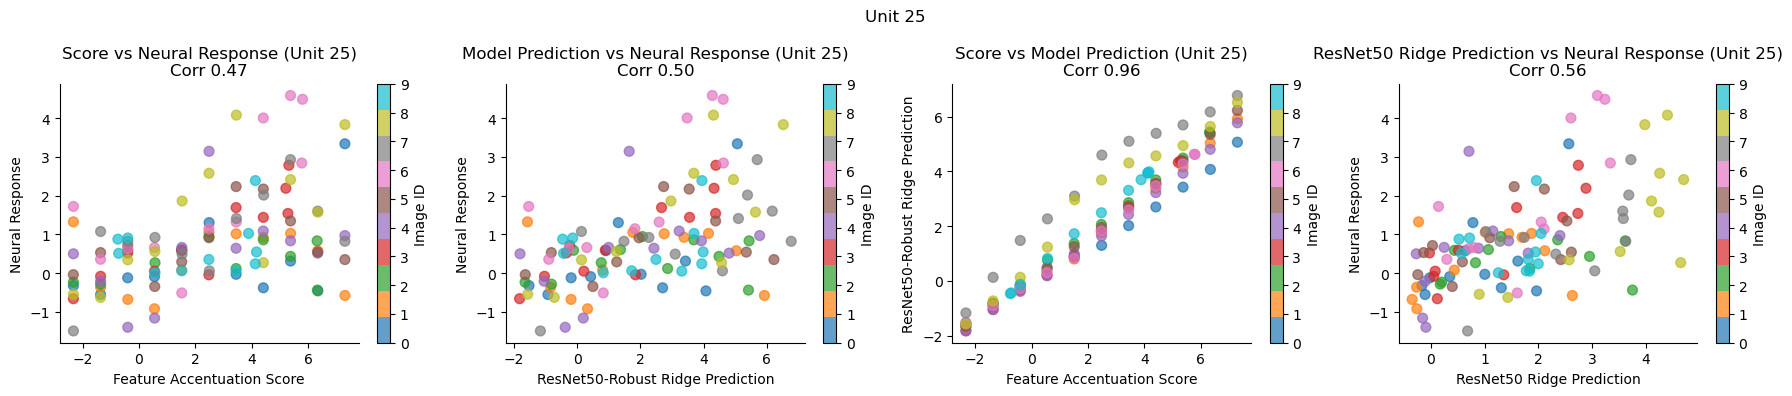

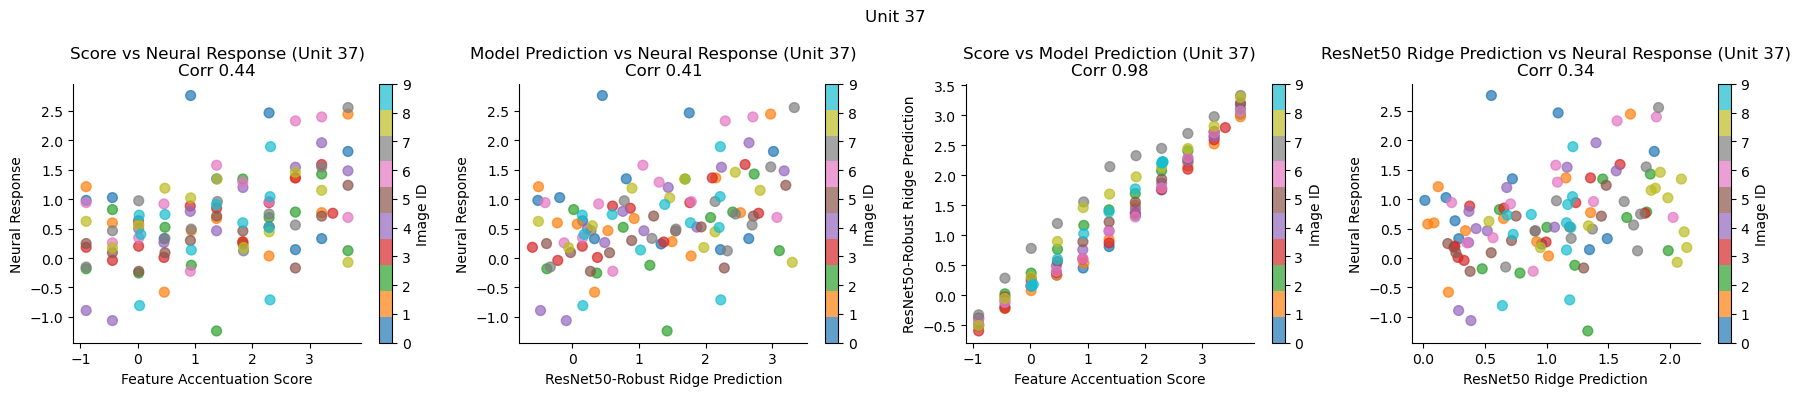

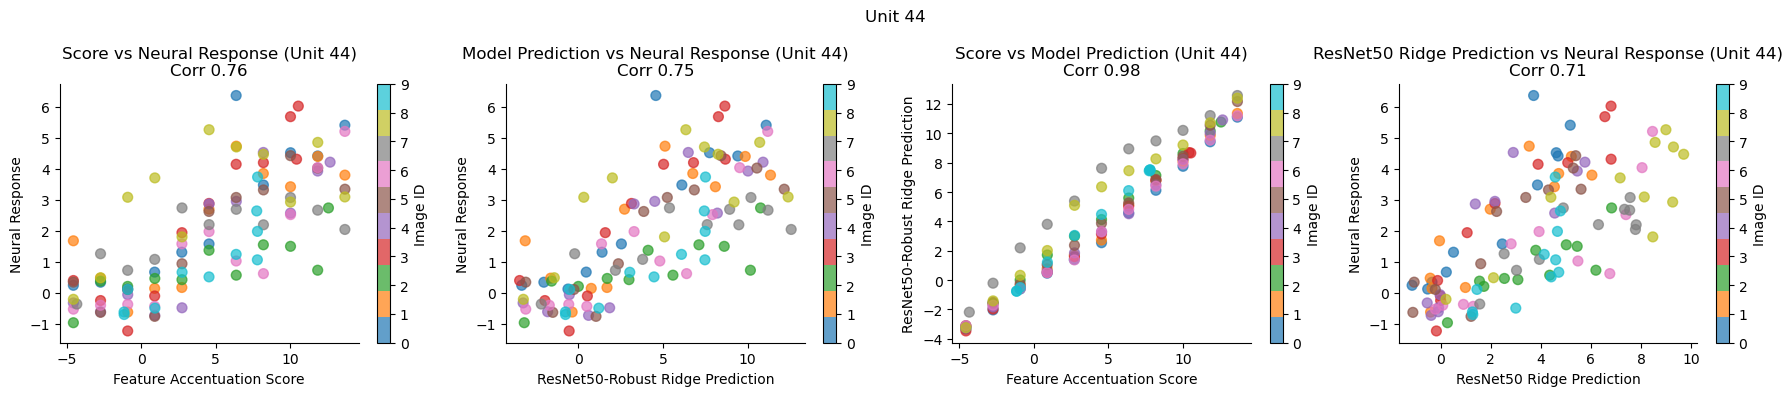

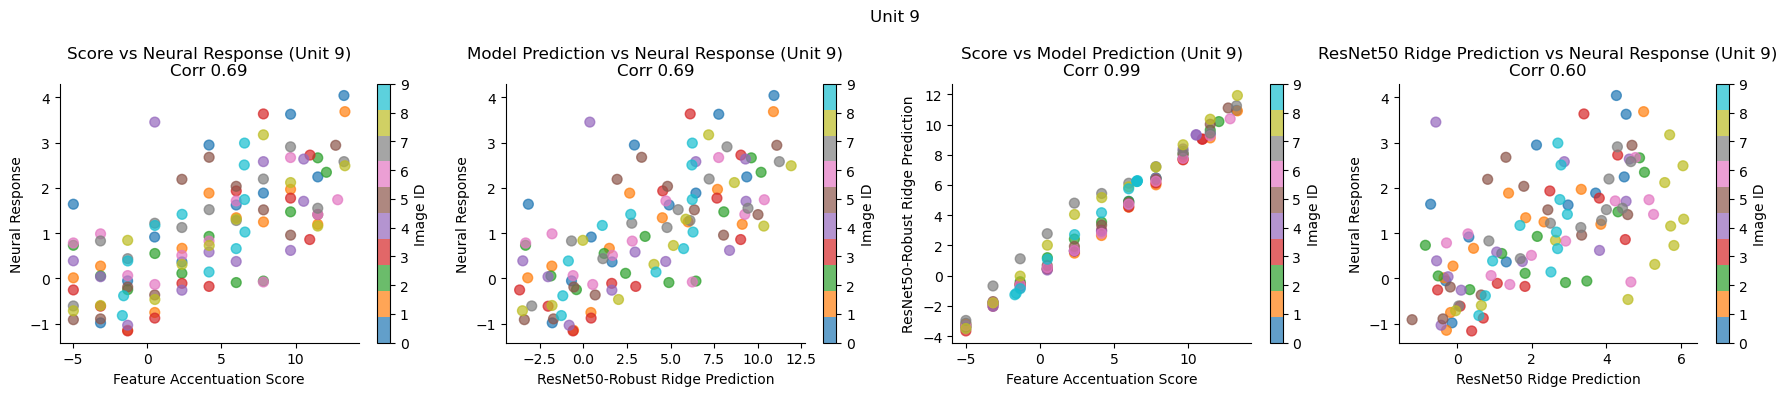

In [197]:
# Common parameters
unit_id = 1
for unit_id in stim_meta_df.unit.unique():
    # if it's not <NA>
    if pd.isna(unit_id):
        continue
    unit_acc_partdf = stim_meta_df.query('accentuated and model == "robust_resnet50" and method == "RidgeCV" and unit == @unit_id')
    idx = unit_acc_partdf.index
    colors = unit_acc_partdf.img
    # Generate all plots using the helper function
    plot_configs = [
        # Score vs Neural Response
        {
            'x': unit_acc_partdf.score,
            'y': ds3.neural_response[idx, unit_id],
            'xlabel': "Feature Accentuation Score",
            'ylabel': "Neural Response",
            'title': f"Score vs Neural Response (Unit {unit_id})"
        },
        # Model Prediction vs Neural Response
        {
            'x': ds3.RN50rbst_Ridge[idx, unit_id],
            'y': ds3.neural_response[idx, unit_id],
            'xlabel': "ResNet50-Robust Ridge Prediction",
            'ylabel': "Neural Response",
            'title': f"Model Prediction vs Neural Response (Unit {unit_id})"
        },
        # Score vs Model Prediction
        {
            'x': unit_acc_partdf.score,
            'y': ds3.RN50rbst_Ridge[idx, unit_id],
            'xlabel': "Feature Accentuation Score",
            'ylabel': "ResNet50-Robust Ridge Prediction", 
            'title': f"Score vs Model Prediction (Unit {unit_id})"
        },
        # Robust Model vs Neural Response
        {
            'x': ds3.RN50_Ridge[idx, unit_id],
            'y': ds3.neural_response[idx, unit_id],
            'xlabel': "ResNet50 Ridge Prediction",
            'ylabel': "Neural Response", 
            'title': f"ResNet50 Ridge Prediction vs Neural Response (Unit {unit_id})"
        }
    ]

    figh, axs = plt.subplots(1, len(plot_configs), figsize=(4.5*len(plot_configs), 4))
    for i, config in enumerate(plot_configs):
        make_scatter_plot(c=colors, ax=axs[i], **config)
    figh.suptitle(f"Unit {unit_id}")
    figh.tight_layout()
    figh.show()


### Quantitative evaluation of reviewer x accentuator

In [13]:
from neural_regress.regress_eval_lib import compute_R2_per_unit

In [14]:
import numpy as np
def compute_R2_per_unit(y_true, y_pred):
    ss_res = np.square(y_true - y_pred).sum(axis=0)
    ss_tot = np.square(y_true - y_true.mean(axis=0)).sum(axis=0)
    return 1 - ss_res / ss_tot

def compute_R2_per_unit_fitmean(y_true, y_pred):
    y_pred_fitmean = y_pred - y_pred.mean(axis=0) + y_true.mean(axis=0)
    ss_res = np.square(y_true - y_pred_fitmean).sum(axis=0)
    ss_tot = np.square(y_true - y_true.mean(axis=0)).sum(axis=0)
    return 1 - ss_res / ss_tot

# similar to this compute correlation coefficient per unit
def compute_corr_per_unit(y_true, y_pred):
    # If the inputs are 1D, compute a single correlation value
    if y_true.ndim == 1 and y_pred.ndim == 1:
        return np.corrcoef(y_true, y_pred)[0, 1]
    # If the inputs are 2D, compute a correlation value per unit
    n_units = y_true.shape[1]
    correlations = np.empty(n_units)
    for i in range(n_units):
        # np.corrcoef returns a 2x2 correlation matrix; [0, 1] is the correlation between the two arrays.
        correlations[i] = np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1]
    return correlations

In [16]:
target_unit_id = 44
accentuator_model = "resnet50"
method = "RidgeCV"
reviewer_model_method = "RN50_Ridge"
unit_acc_partdf = stim_meta_df.query('accentuated and model == @accentuator_model and method == @method and unit == @target_unit_id')
for reviewer_model_method in ["RN50_Ridge", "RN50_Lasso", "RN50rbst_Ridge", "RN50rbst_Lasso"]:
    R2 = compute_R2_per_unit(ds3.neural_response[unit_acc_partdf.index, target_unit_id], ds3[reviewer_model_method][unit_acc_partdf.index, target_unit_id],)
    R2_fitmean = compute_R2_per_unit_fitmean(ds3.neural_response[unit_acc_partdf.index, target_unit_id], ds3[reviewer_model_method][unit_acc_partdf.index, target_unit_id],)
    corr = compute_corr_per_unit(ds3.neural_response[unit_acc_partdf.index, target_unit_id], ds3[reviewer_model_method][unit_acc_partdf.index, target_unit_id],)
    print("Accentuator", f"{accentuator_model}-{method}", "Reviewer", reviewer_model_method, "R2", R2.item(), "R2_fitmean", R2_fitmean.item(), "corr", corr.item())

Accentuator resnet50-RidgeCV Reviewer RN50_Ridge R2 -6.845836156455792 R2_fitmean -3.518794703291154 corr 0.6111909408396581
Accentuator resnet50-RidgeCV Reviewer RN50_Lasso R2 -3.7571159508510865 R2_fitmean -1.231032383606944 corr 0.6709544814566142
Accentuator resnet50-RidgeCV Reviewer RN50rbst_Ridge R2 -3.0704432838241136 R2_fitmean -1.6693388936266818 corr 0.713929209439591
Accentuator resnet50-RidgeCV Reviewer RN50rbst_Lasso R2 -2.835670585105348 R2_fitmean -1.6328844710296 corr 0.701953484967363


In [140]:
stim_meta_df.unit.unique()

<IntegerArray>
[<NA>, 15, 16, 1, 25, 37, 44, 9]
Length: 8, dtype: Int64

In [17]:
target_unit_id = 15
accentuator_model = "resnet50"
method = "RidgeCV"
for accentuator_model in ["resnet50", "robust_resnet50"]:
    for method in ["RidgeCV", "MultiLassoCV"]:
        unit_acc_partdf = stim_meta_df.query('accentuated and model == @accentuator_model and method == @method and unit == @target_unit_id')
        stim_index = unit_acc_partdf.index
        for reviewer_model_method in ["RN50_Ridge", "RN50_Lasso", "RN50rbst_Ridge", "RN50rbst_Lasso"]:
            R2 = compute_R2_per_unit(ds3.neural_response[stim_index, target_unit_id], ds3[reviewer_model_method][stim_index, target_unit_id],)
            corr = compute_corr_per_unit(ds3.neural_response[stim_index, target_unit_id], ds3[reviewer_model_method][stim_index, target_unit_id],)
            print("Accentuator", f"{accentuator_model}-{method}", "| Reviewer", reviewer_model_method, "| R2", R2.item(), " corr", corr.item())

Accentuator resnet50-RidgeCV | Reviewer RN50_Ridge | R2 -3.6464906864811324  corr 0.4960629343414368
Accentuator resnet50-RidgeCV | Reviewer RN50_Lasso | R2 -3.0303776263147233  corr 0.5550621681082939
Accentuator resnet50-RidgeCV | Reviewer RN50rbst_Ridge | R2 -1.7112257198077412  corr 0.5884994962266642
Accentuator resnet50-RidgeCV | Reviewer RN50rbst_Lasso | R2 -1.6587525172362332  corr 0.5715741548393639
Accentuator resnet50-MultiLassoCV | Reviewer RN50_Ridge | R2 -3.9434453011083805  corr 0.504913928539742
Accentuator resnet50-MultiLassoCV | Reviewer RN50_Lasso | R2 -4.186090405984942  corr 0.530586067923966
Accentuator resnet50-MultiLassoCV | Reviewer RN50rbst_Ridge | R2 -2.4660757940579465  corr 0.5498418554480331
Accentuator resnet50-MultiLassoCV | Reviewer RN50rbst_Lasso | R2 -2.330804155123779  corr 0.5481935924292226
Accentuator robust_resnet50-RidgeCV | Reviewer RN50_Ridge | R2 0.02048771003294514  corr 0.6143323537437628
Accentuator robust_resnet50-RidgeCV | Reviewer RN50_

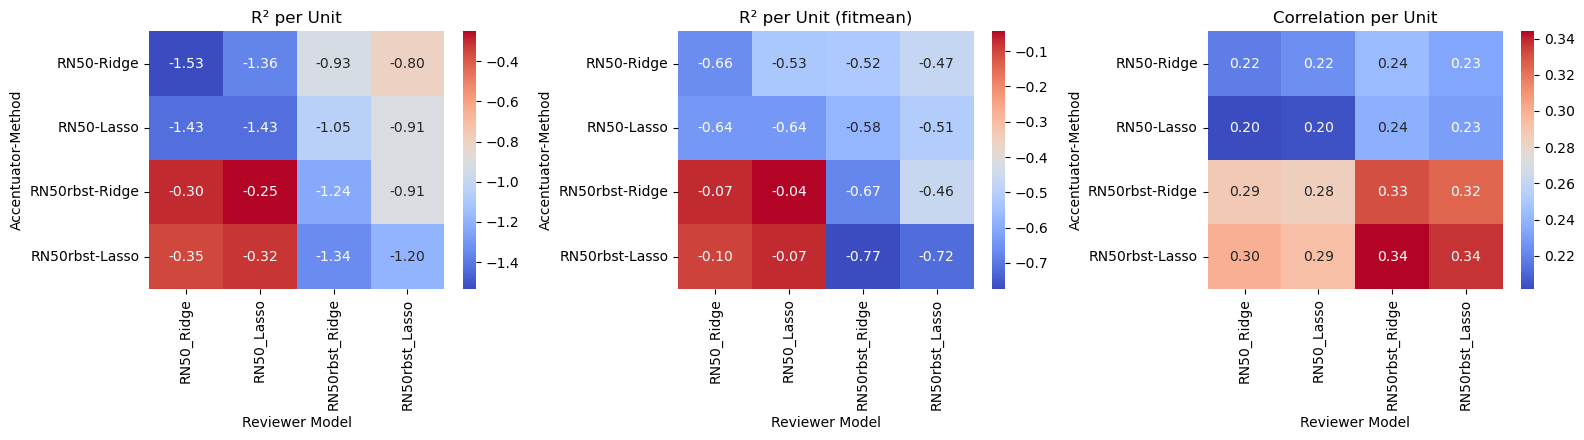

In [153]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Define your models and methods.
accentuator_models = ["resnet50", "robust_resnet50"]
methods = ["RidgeCV", "MultiLassoCV"]
reviewer_methods = ["RN50_Ridge", "RN50_Lasso", "RN50rbst_Ridge", "RN50rbst_Lasso"]
target_unit_id = 16
population_mask = slice(None)
# Create row labels (e.g., "resnet50-RidgeCV")
row_labels = [f"{am}-{m}" for am in accentuator_models for m in methods]

# Initialize DataFrames to store R2 and correlation values.
R2_df = pd.DataFrame(index=row_labels, columns=reviewer_methods)
corr_df = pd.DataFrame(index=row_labels, columns=reviewer_methods)
R2_fitmean_df = pd.DataFrame(index=row_labels, columns=reviewer_methods)
# Loop over each combination and compute metrics.
for accentuator_model in accentuator_models:
    for method in methods:
        # Create a row key for the DataFrame.
        row_key = f"{accentuator_model}-{method}"
        # Filter stim_meta_df based on your criteria.
        unit_acc_partdf = stim_meta_df.query('accentuated and model == @accentuator_model and method == @method') #  and unit == @target_unit_id
        stim_index = unit_acc_partdf.index
        # Loop over each reviewer method and compute R2 and correlation.
        for reviewer_model_method in reviewer_methods:
            R2 = compute_R2_per_unit(ds3.neural_response[stim_index, population_mask],
                                       ds3[reviewer_model_method][stim_index, population_mask])
            R2_fitmean = compute_R2_per_unit_fitmean(ds3.neural_response[stim_index, population_mask],
                                                    ds3[reviewer_model_method][stim_index, population_mask])
            corr = compute_corr_per_unit(ds3.neural_response[stim_index, population_mask],
                                         ds3[reviewer_model_method][stim_index, population_mask])
            R2_df.loc[row_key, reviewer_model_method] = R2.mean().item()
            R2_fitmean_df.loc[row_key, reviewer_model_method] = R2_fitmean.mean().item()
            corr_df.loc[row_key, reviewer_model_method] = corr.mean().item()

# Convert values to float for proper plotting.
R2_df = R2_df.astype(float)
corr_df = corr_df.astype(float)
R2_fitmean_df = R2_fitmean_df.astype(float)
shorten_func = lambda x: x.replace('robust_resnet50-', 'RN50rbst-').replace('resnet50-', 'RN50-').replace('RidgeCV', 'Ridge').replace('MultiLassoCV', 'Lasso')
# Plot heatmaps for R2 and correlation.
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
sns.heatmap(R2_df, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0], 
            yticklabels=[shorten_func(l) for l in R2_df.index])
axes[0].set_title("R² per Unit")
axes[0].set_xlabel("Reviewer Model")
axes[0].set_ylabel("Accentuator-Method")
sns.heatmap(R2_fitmean_df, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1], 
            yticklabels=[shorten_func(l) for l in R2_fitmean_df.index])
axes[1].set_title("R² per Unit (fitmean)")
axes[1].set_xlabel("Reviewer Model")
axes[1].set_ylabel("Accentuator-Method")
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[2], 
            yticklabels=[shorten_func(l) for l in corr_df.index])
axes[2].set_title("Correlation per Unit")
axes[2].set_xlabel("Reviewer Model")
axes[2].set_ylabel("Accentuator-Method")
plt.tight_layout()
plt.show()

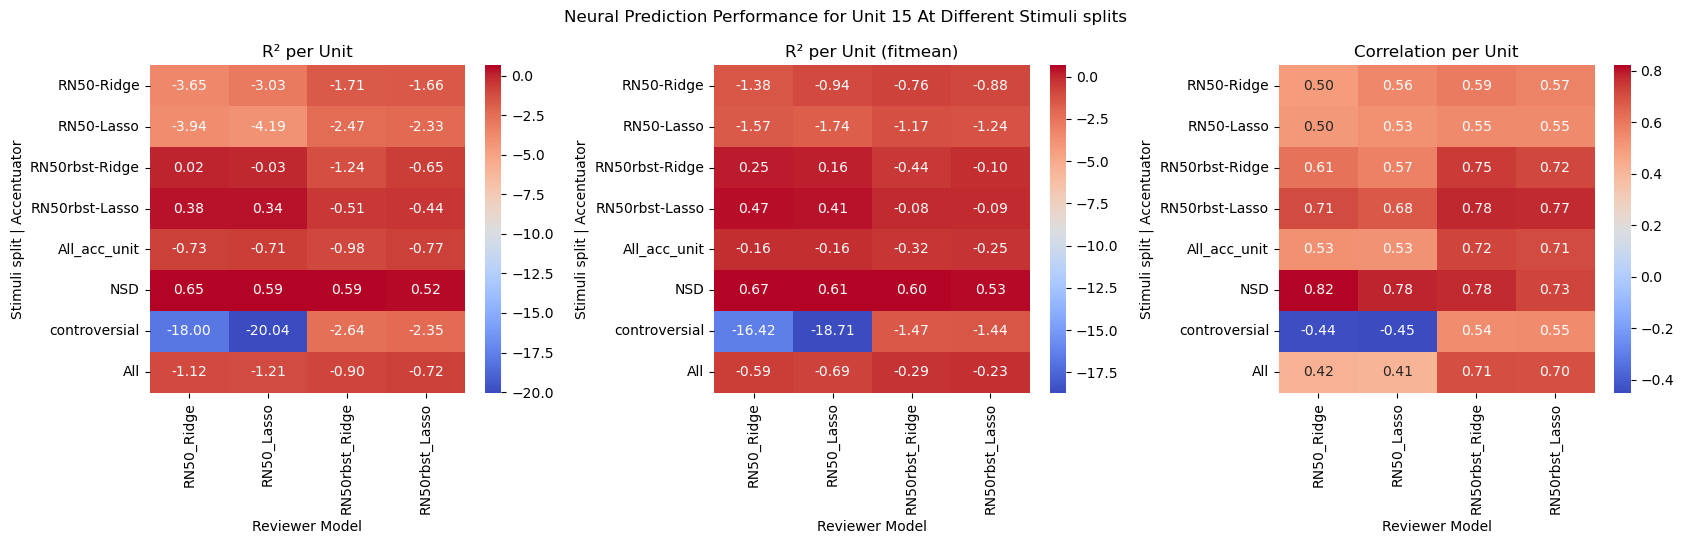

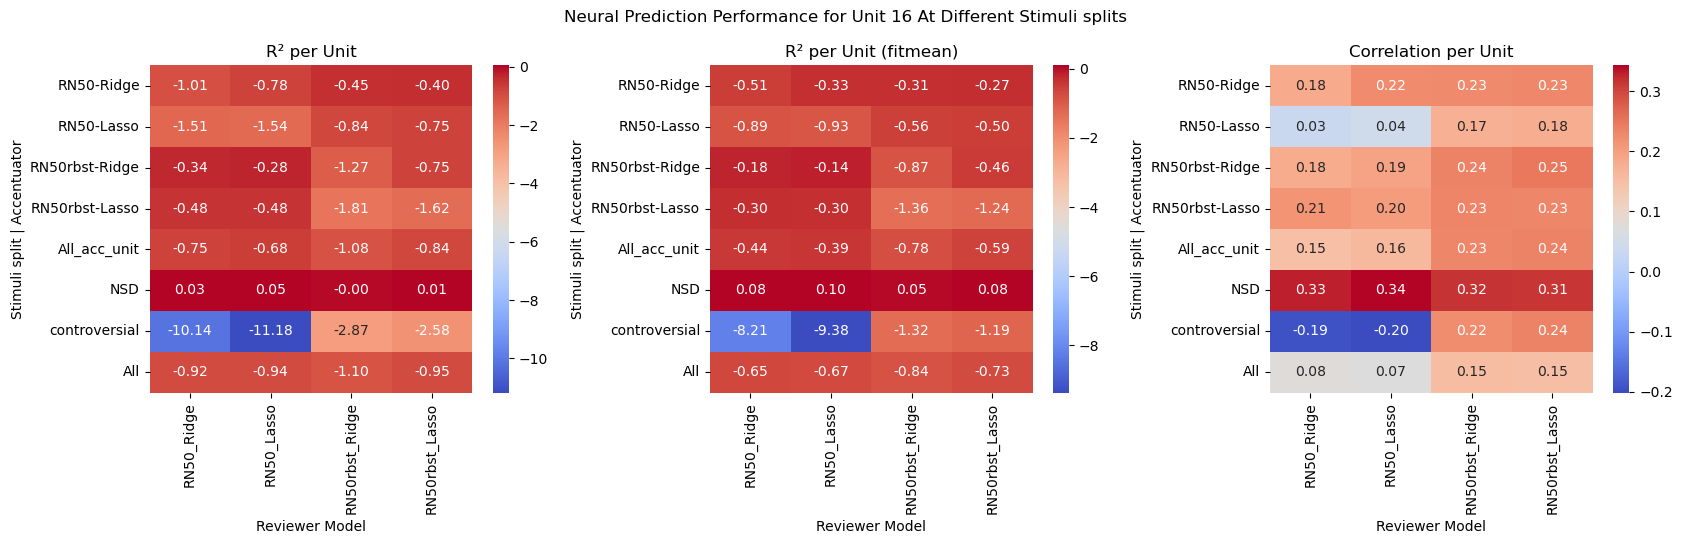

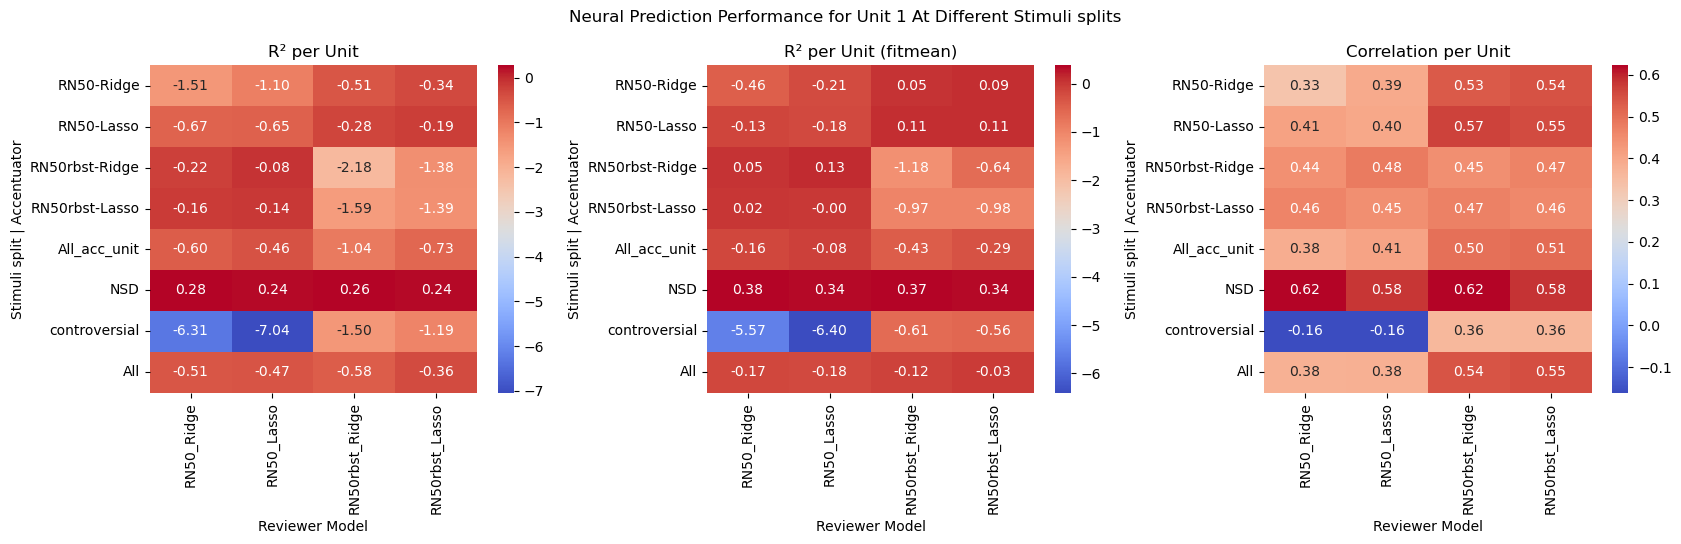

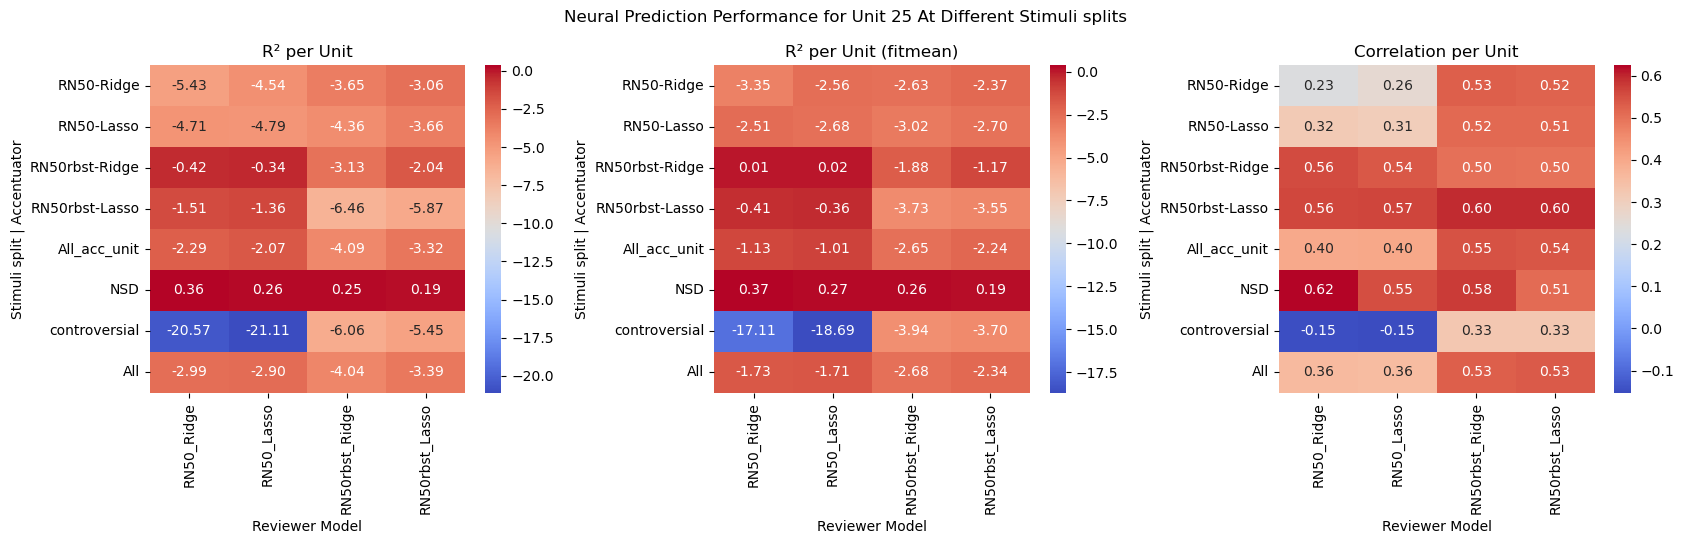

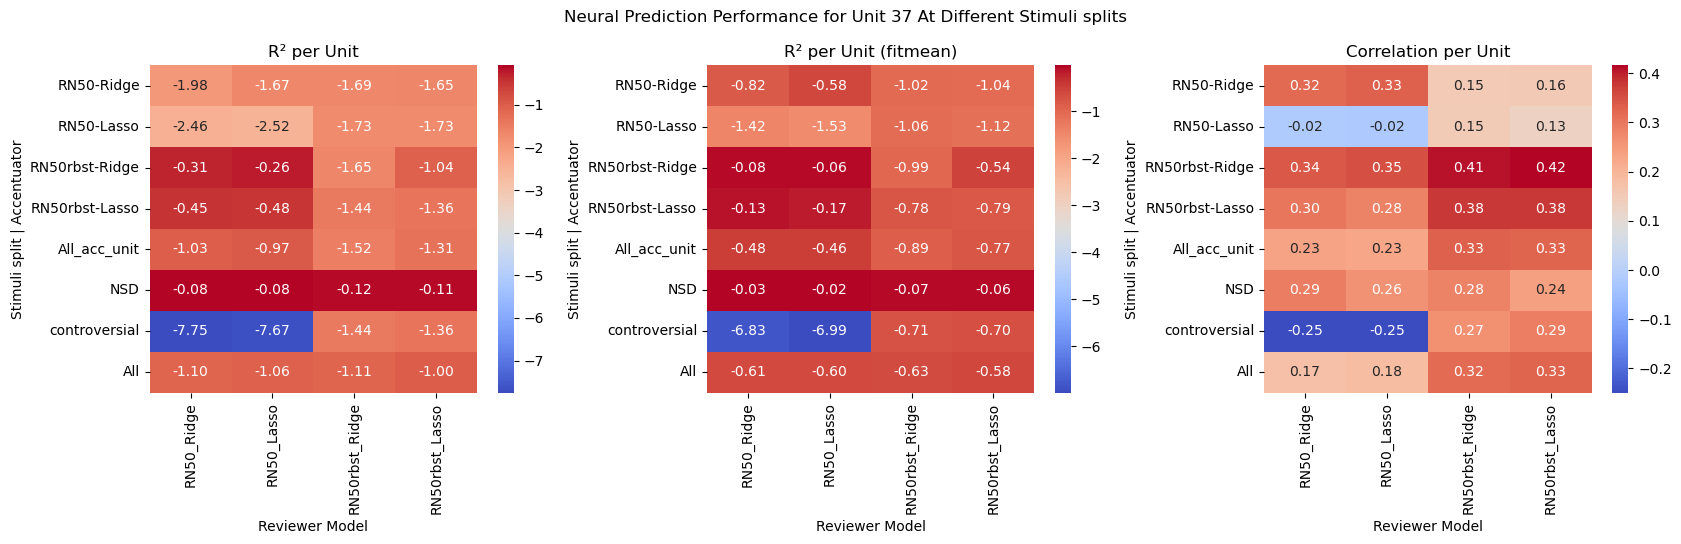

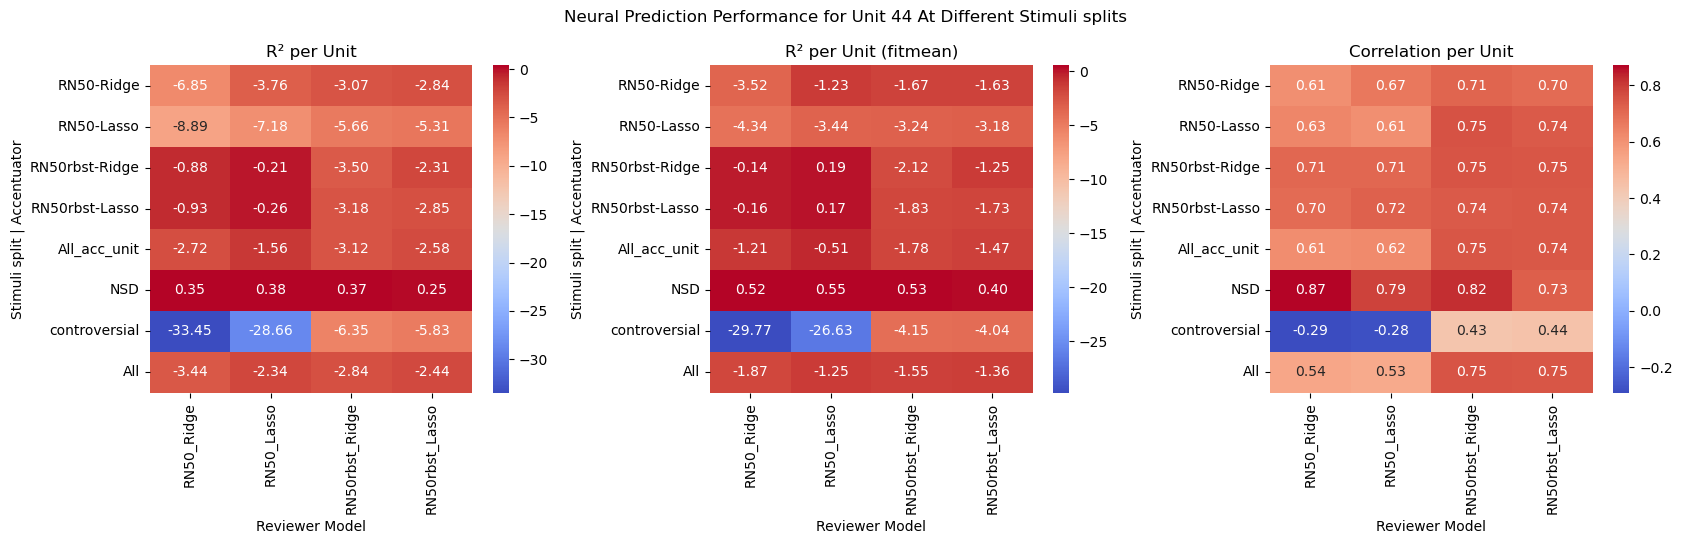

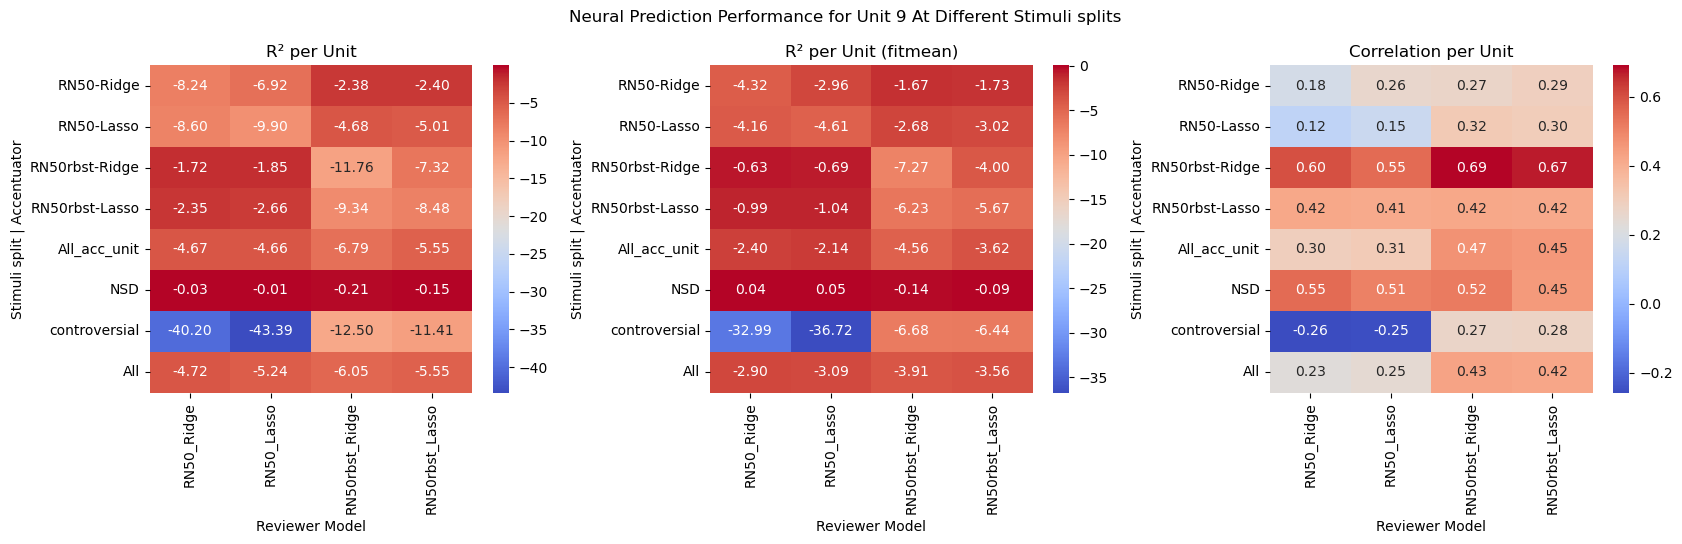

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
figoutdir = "/n/home12/binxuwang/Github/Closed-loop-visual-insilico/figures/red_20250123-20250126/peer_review"
# Define your models and methods.
accentuator_models = ["resnet50", "robust_resnet50"]
methods = ["RidgeCV", "MultiLassoCV"]
reviewer_methods = ["RN50_Ridge", "RN50_Lasso", "RN50rbst_Ridge", "RN50rbst_Lasso"]
shorten_func = lambda x: x.replace('robust_resnet50-', 'RN50rbst-').replace('resnet50-', 'RN50-').replace('RidgeCV', 'Ridge').replace('MultiLassoCV', 'Lasso')
target_unit_id = 16
for target_unit_id in stim_meta_df.unit.unique():
    if pd.isna(target_unit_id):
        continue
    stimuli_splits = {}
    for accentuator_model in accentuator_models:
        for method in methods:
            stimuli_splits[f"{accentuator_model}-{method}"] = \
                stim_meta_df.query('accentuated and model == @accentuator_model and method == @method and unit == @target_unit_id')
    stimuli_splits["All_acc_unit"] = stim_meta_df.query('accentuated and unit == @target_unit_id')
    stimuli_splits["NSD"] = stim_meta_df.query('is_nsd')
    stimuli_splits["controversial"] = stim_meta_df.query('is_controversial')
    stimuli_splits["All"] = stim_meta_df
    
    # Create row labels (e.g., "resnet50-RidgeCV")
    row_labels = list(stimuli_splits.keys());
    # Initialize DataFrames to store R2 and correlation values.
    R2_df = pd.DataFrame(index=row_labels, columns=reviewer_methods)
    corr_df = pd.DataFrame(index=row_labels, columns=reviewer_methods)
    R2_fitmean_df = pd.DataFrame(index=row_labels, columns=reviewer_methods)

    for split_name, split_df in stimuli_splits.items():
        stim_index = split_df.index
        # Loop over each reviewer method and compute R2 and correlation.
        for reviewer_model_method in reviewer_methods:
            R2 = compute_R2_per_unit(ds3.neural_response[stim_index, target_unit_id],
                                        ds3[reviewer_model_method][stim_index, target_unit_id])
            R2_fitmean = compute_R2_per_unit_fitmean(ds3.neural_response[stim_index, target_unit_id],
                                                    ds3[reviewer_model_method][stim_index, target_unit_id])
            corr = compute_corr_per_unit(ds3.neural_response[stim_index, target_unit_id],
                                            ds3[reviewer_model_method][stim_index, target_unit_id])
            R2_df.loc[split_name, reviewer_model_method] = R2.item()
            R2_fitmean_df.loc[split_name, reviewer_model_method] = R2_fitmean.item()
            corr_df.loc[split_name, reviewer_model_method] = corr.item()

    # Convert values to float for proper plotting.
    R2_df = R2_df.astype(float)
    R2_fitmean_df = R2_fitmean_df.astype(float)
    corr_df = corr_df.astype(float)

    # Plot heatmaps for R2 and correlation.
    fig, axes = plt.subplots(1, 3, figsize=(17, 5.5))
    sns.heatmap(R2_df, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0], 
                yticklabels=[shorten_func(l) for l in R2_df.index])
    axes[0].set_title("R² per Unit")
    axes[0].set_xlabel("Reviewer Model")
    axes[0].set_ylabel("Stimuli split | Accentuator")
    sns.heatmap(R2_fitmean_df, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1], 
                yticklabels=[shorten_func(l) for l in R2_fitmean_df.index])
    axes[1].set_title("R² per Unit (fitmean)")
    axes[1].set_xlabel("Reviewer Model")
    axes[1].set_ylabel("Stimuli split | Accentuator")
    sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[2], 
                yticklabels=[shorten_func(l) for l in corr_df.index])
    axes[2].set_title("Correlation per Unit")
    axes[2].set_xlabel("Reviewer Model")
    axes[2].set_ylabel("Stimuli split | Accentuator")
    plt.suptitle(f"Neural Prediction Performance for Unit {target_unit_id} At Different Stimuli splits")
    plt.tight_layout()
    saveallforms(figoutdir, f"neural_prediction_performance_unit_{target_unit_id}_all_stimuli_splits_peer_review")
    plt.show()

### Collect peer review statistics and synopsis

In [41]:
figoutdir

'/n/home12/binxuwang/Github/Closed-loop-visual-insilico/figures/red_20250123-20250126/peer_review'

### Symopsis

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
figoutdir = "/n/home12/binxuwang/Github/Closed-loop-visual-insilico/figures/red_20250123-20250126/peer_review"
# Define your models and methods.
accentuator_models = ["resnet50", "robust_resnet50"]
methods = ["RidgeCV", "MultiLassoCV"]
reviewer_methods = ["RN50_Ridge", "RN50_Lasso", "RN50rbst_Ridge", "RN50rbst_Lasso"]
shorten_func = lambda x: x.replace('robust_resnet50-', 'RN50rbst-').replace('resnet50-', 'RN50-').replace('RidgeCV', 'Ridge').replace('MultiLassoCV', 'Lasso')
target_unit_id = 16
R2_df_col = []
R2_fitmean_df_col = []
corr_df_col = []
for target_unit_id in stim_meta_df.unit.unique():
    if pd.isna(target_unit_id):
        continue
    stimuli_splits = {}
    for accentuator_model in accentuator_models:
        for method in methods:
            stimuli_splits[f"{accentuator_model}-{method}"] = \
                stim_meta_df.query('accentuated and model == @accentuator_model and method == @method and unit == @target_unit_id')
    stimuli_splits["All_acc_unit"] = stim_meta_df.query('accentuated and unit == @target_unit_id')
    stimuli_splits["NSD"] = stim_meta_df.query('is_nsd')
    stimuli_splits["controversial"] = stim_meta_df.query('is_controversial')
    stimuli_splits["All"] = stim_meta_df
    
    # Create row labels (e.g., "resnet50-RidgeCV")
    row_labels = list(stimuli_splits.keys());
    # Initialize DataFrames to store R2 and correlation values.
    R2_df = pd.DataFrame(index=row_labels, columns=reviewer_methods)
    corr_df = pd.DataFrame(index=row_labels, columns=reviewer_methods)
    R2_fitmean_df = pd.DataFrame(index=row_labels, columns=reviewer_methods)

    for split_name, split_df in stimuli_splits.items():
        stim_index = split_df.index
        # Loop over each reviewer method and compute R2 and correlation.
        for reviewer_model_method in reviewer_methods:
            R2 = compute_R2_per_unit(ds3.neural_response[stim_index, target_unit_id],
                                        ds3[reviewer_model_method][stim_index, target_unit_id])
            R2_fitmean = compute_R2_per_unit_fitmean(ds3.neural_response[stim_index, target_unit_id],
                                                    ds3[reviewer_model_method][stim_index, target_unit_id])
            corr = compute_corr_per_unit(ds3.neural_response[stim_index, target_unit_id],
                                            ds3[reviewer_model_method][stim_index, target_unit_id])
            R2_df.loc[split_name, reviewer_model_method] = R2.item()
            R2_fitmean_df.loc[split_name, reviewer_model_method] = R2_fitmean.item()
            corr_df.loc[split_name, reviewer_model_method] = corr.item()

    # Convert values to float for proper plotting.
    R2_df = R2_df.astype(float)
    R2_fitmean_df = R2_fitmean_df.astype(float)
    corr_df = corr_df.astype(float)
    R2_df_col.append(R2_df)
    R2_fitmean_df_col.append(R2_fitmean_df)
    corr_df_col.append(corr_df)


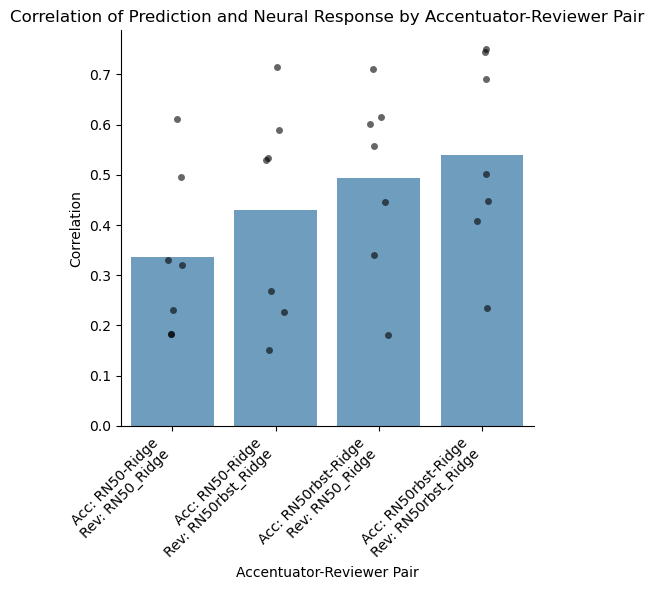

In [42]:
keys = [("resnet50-RidgeCV", "RN50_Ridge"), ("resnet50-RidgeCV", "RN50rbst_Ridge"), ("robust_resnet50-RidgeCV", "RN50_Ridge"), ("robust_resnet50-RidgeCV", "RN50rbst_Ridge")]
abbr_keys = [("RN50-Ridge", "RN50_Ridge"), ("RN50-Ridge", "RN50rbst_Ridge"), ("RN50rbst-Ridge", "RN50_Ridge"), ("RN50rbst-Ridge", "RN50rbst_Ridge")]
# Prepare data for plotting
data_for_df = []
for key, abbr_key in zip(keys, abbr_keys):
    vals = [df.loc[key[0], key[1]] for df in corr_df_col]
    for val in vals:
        data_for_df.append({
            'Accentuator-Reviewer Pair': f"Acc: {abbr_key[0]}\nRev: {abbr_key[1]}",
            'Correlation': val
        })

# Create DataFrame for seaborn
plot_df = pd.DataFrame(data_for_df)
# Create a figure for the bar plot
plt.figure(figsize=(5, 6))
# Use seaborn's barplot with individual points
ax = sns.barplot(x='Accentuator-Reviewer Pair', y='Correlation', data=plot_df, 
                 estimator=np.mean, errorbar=None, alpha=0.7)
# Add individual data points with jitter
sns.stripplot(x='Accentuator-Reviewer Pair', y='Correlation', data=plot_df,
              color='black', alpha=0.6, size=5, jitter=True)

# Add title and adjust layout
plt.title('Correlation of Prediction and Neural Response by Accentuator-Reviewer Pair')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
saveallforms(figoutdir, f"correlation_of_prediction_and_neural_response_summary_RidgeModel_peer_review")
plt.show()

In [17]:
subplot_data

Accentuator-Reviewer Pair  Correlation
0  Acc: RN50-Ridge\nRev: RN50_Ridge     0.496063
1  Acc: RN50-Ridge\nRev: RN50_Ridge     0.182284
2  Acc: RN50-Ridge\nRev: RN50_Ridge     0.330619
3  Acc: RN50-Ridge\nRev: RN50_Ridge     0.231532
4  Acc: RN50-Ridge\nRev: RN50_Ridge     0.320397
5  Acc: RN50-Ridge\nRev: RN50_Ridge     0.611191
6  Acc: RN50-Ridge\nRev: RN50_Ridge     0.182141

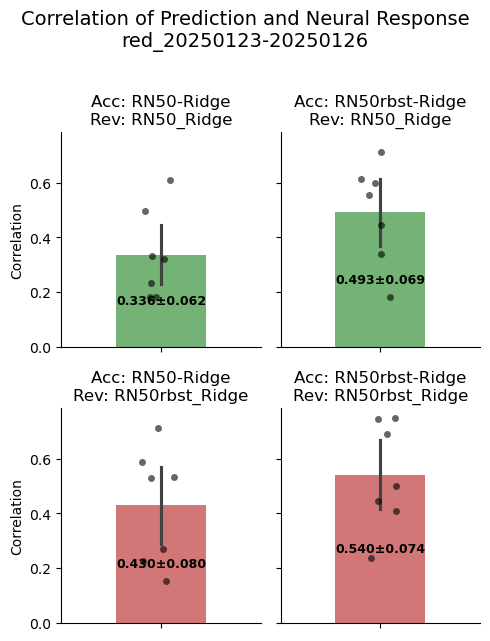

In [33]:
keys = [("resnet50-RidgeCV", "RN50_Ridge"), ("resnet50-RidgeCV", "RN50rbst_Ridge"), ("robust_resnet50-RidgeCV", "RN50_Ridge"), ("robust_resnet50-RidgeCV", "RN50rbst_Ridge")]
abbr_keys = [("RN50-Ridge", "RN50_Ridge"), ("RN50-Ridge", "RN50rbst_Ridge"), ("RN50rbst-Ridge", "RN50_Ridge"), ("RN50rbst-Ridge", "RN50rbst_Ridge")]
# Prepare data for plotting
data_for_df = []
for key, abbr_key in zip(keys, abbr_keys):
    vals = [df.loc[key[0], key[1]] for df in corr_df_col]
    for val in vals:
        data_for_df.append({
            'Accentuator-Reviewer Pair': f"Acc: {abbr_key[0]}\nRev: {abbr_key[1]}",
            'Correlation': val
        })

# Create DataFrame for seaborn
plot_df = pd.DataFrame(data_for_df)
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(5, 6.5), sharex=False, sharey=True)
axes = axes.flatten()
# Define the accentuators and reviewers
accentuators = ["RN50-Ridge", "RN50rbst-Ridge"]
reviewers = ["RN50_Ridge", "RN50rbst_Ridge"]

# Plot each combination in its own subplot
for i, reviewer in enumerate(reviewers):
    for j, accentuator in enumerate(accentuators):
        # Filter data for this accentuator-reviewer pair
        subplot_data = plot_df[plot_df['Accentuator-Reviewer Pair'] == f"Acc: {accentuator}\nRev: {reviewer}"]
        # Calculate subplot index (0, 1, 2, 3)
        idx = i * 2 + j
        # Create barplot in the appropriate subplot
        sns.barplot(x='Accentuator-Reviewer Pair', y='Correlation', data=subplot_data, 
                   estimator=np.mean, errorbar="ci", alpha=0.7, ax=axes[idx], width=0.45,
                   color="C2" if i==0 else "C3")
        # Add individual data points
        sns.stripplot(x='Accentuator-Reviewer Pair', y='Correlation', data=subplot_data,
                     color='black', alpha=0.6, size=5, jitter=True, ax=axes[idx])
        
        # Calculate mean and SEM for annotation
        mean_val = subplot_data['Correlation'].mean()
        sem_val = subplot_data['Correlation'].sem()
        # Add mean ± SEM annotation on the bar
        axes[idx].text(0, mean_val/2, f"{mean_val:.3f}±{sem_val:.3f}", 
                      ha='center', va='center', fontsize=9, fontweight='bold')
        
        # Set subplot title
        axes[idx].set_title(f"Acc: {accentuator}\nRev: {reviewer}")
        axes[idx].set_xlabel('')
        # remove the xticks label
        axes[idx].set_xticklabels([])
        # Only set y-label for leftmost subplots
        if j == 0:
            axes[idx].set_ylabel('Correlation')
        else:
            axes[idx].set_ylabel('')

# Add overall title
plt.suptitle(f'Correlation of Prediction and Neural Response\n{subject_id3}', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for suptitle
saveallforms(figoutdir, f"correlation_of_prediction_and_neural_response_2x2_grid_RidgeModel_peer_review")
plt.show()

In [34]:
figoutdir

'/n/home12/binxuwang/Github/Closed-loop-visual-insilico/figures/red_20250123-20250126/peer_review'

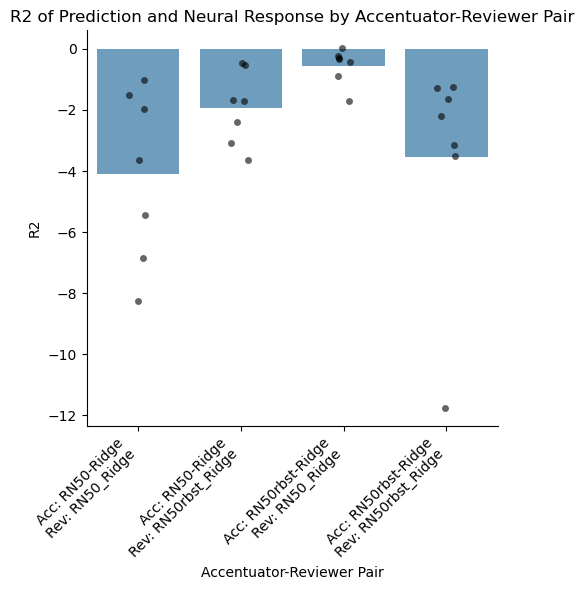

In [45]:
keys = [("resnet50-RidgeCV", "RN50_Ridge"), ("resnet50-RidgeCV", "RN50rbst_Ridge"), ("robust_resnet50-RidgeCV", "RN50_Ridge"), ("robust_resnet50-RidgeCV", "RN50rbst_Ridge")]
abbr_keys = [("RN50-Ridge", "RN50_Ridge"), ("RN50-Ridge", "RN50rbst_Ridge"), ("RN50rbst-Ridge", "RN50_Ridge"), ("RN50rbst-Ridge", "RN50rbst_Ridge")]
# Prepare data for plotting
data_for_df = []
for key, abbr_key in zip(keys, abbr_keys):
    vals = [df.loc[key[0], key[1]] for df in R2_df_col]
    for val in vals:
        data_for_df.append({
            'Accentuator-Reviewer Pair': f"Acc: {abbr_key[0]}\nRev: {abbr_key[1]}",
            'R2': val
        })

# Create DataFrame for seaborn
plot_df = pd.DataFrame(data_for_df)
# Create a figure for the bar plot
plt.figure(figsize=(5, 6))
# Use seaborn's barplot with individual points
ax = sns.barplot(x='Accentuator-Reviewer Pair', y='R2', data=plot_df, 
                 estimator=np.mean, errorbar=None, alpha=0.7)
# Add individual data points with jitter
sns.stripplot(x='Accentuator-Reviewer Pair', y='R2', data=plot_df,
              color='black', alpha=0.6, size=5, jitter=True)
# Add title and adjust layout
plt.title('R2 of Prediction and Neural Response by Accentuator-Reviewer Pair')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
saveallforms(figoutdir, f"R2_of_prediction_and_neural_response_summary_RidgeModel_peer_review")
plt.show()

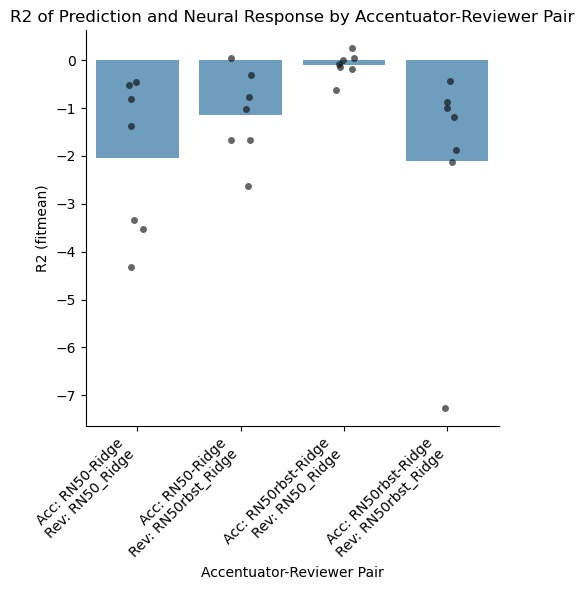

In [46]:
keys = [("resnet50-RidgeCV", "RN50_Ridge"), ("resnet50-RidgeCV", "RN50rbst_Ridge"), ("robust_resnet50-RidgeCV", "RN50_Ridge"), ("robust_resnet50-RidgeCV", "RN50rbst_Ridge")]
abbr_keys = [("RN50-Ridge", "RN50_Ridge"), ("RN50-Ridge", "RN50rbst_Ridge"), ("RN50rbst-Ridge", "RN50_Ridge"), ("RN50rbst-Ridge", "RN50rbst_Ridge")]
# Prepare data for plotting
data_for_df = []
for key, abbr_key in zip(keys, abbr_keys):
    vals = [df.loc[key[0], key[1]] for df in R2_fitmean_df_col]
    for val in vals:
        data_for_df.append({
            'Accentuator-Reviewer Pair': f"Acc: {abbr_key[0]}\nRev: {abbr_key[1]}",
            'R2 (fitmean)': val
        })

# Create DataFrame for seaborn
plot_df = pd.DataFrame(data_for_df)
# Create a figure for the bar plot
plt.figure(figsize=(5, 6))
# Use seaborn's barplot with individual points
ax = sns.barplot(x='Accentuator-Reviewer Pair', y='R2 (fitmean)', data=plot_df, 
                 estimator=np.mean, errorbar=None, alpha=0.7)
# Add individual data points with jitter
sns.stripplot(x='Accentuator-Reviewer Pair', y='R2 (fitmean)', data=plot_df,
              color='black', alpha=0.6, size=5, jitter=True)
# Add title and adjust layout
plt.title('R2 of Prediction and Neural Response by Accentuator-Reviewer Pair')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
saveallforms(figoutdir, f"R2_fitmean_of_prediction_and_neural_response_summary_RidgeModel_peer_review")
plt.show()

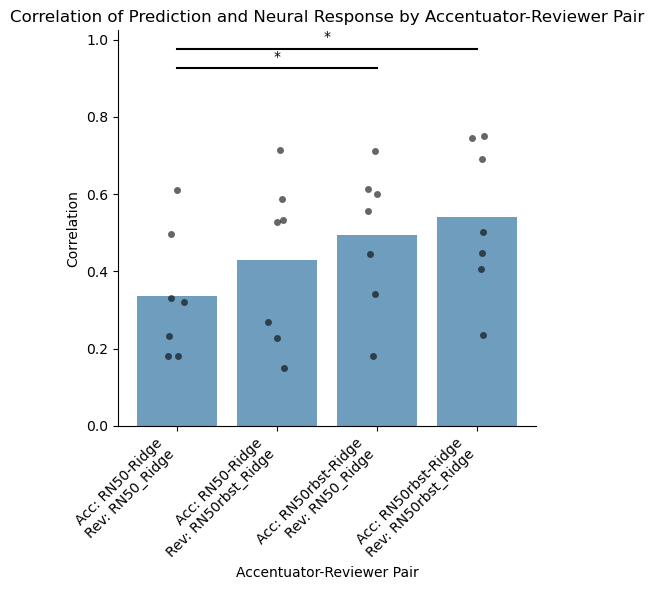

In [44]:
keys = [("resnet50-RidgeCV", "RN50_Ridge"), ("resnet50-RidgeCV", "RN50rbst_Ridge"), ("robust_resnet50-RidgeCV", "RN50_Ridge"), ("robust_resnet50-RidgeCV", "RN50rbst_Ridge")]
abbr_keys = [("RN50-Ridge", "RN50_Ridge"), ("RN50-Ridge", "RN50rbst_Ridge"), ("RN50rbst-Ridge", "RN50_Ridge"), ("RN50rbst-Ridge", "RN50rbst_Ridge")]
# Prepare data for plotting
data_for_df = []
for key, abbr_key in zip(keys, abbr_keys):
    vals = [df.loc[key[0], key[1]] for df in corr_df_col]
    for val in vals:
        data_for_df.append({
            'Accentuator-Reviewer Pair': f"Acc: {abbr_key[0]}\nRev: {abbr_key[1]}",
            'Correlation': val,
            'Accentuator': abbr_key[0],
            'Reviewer': abbr_key[1]
        })

# Create DataFrame for seaborn
plot_df = pd.DataFrame(data_for_df)

# Perform paired t-tests between different pairs
from scipy import stats
p_values = {}
# Get unique pairs for comparison
unique_pairs = plot_df['Accentuator-Reviewer Pair'].unique()
# Perform t-test for all combinations
for i in range(len(unique_pairs)):
    for j in range(i+1, len(unique_pairs)):
        pair1 = unique_pairs[i]
        pair2 = unique_pairs[j]
        vals1 = plot_df[plot_df['Accentuator-Reviewer Pair'] == pair1]['Correlation'].values
        vals2 = plot_df[plot_df['Accentuator-Reviewer Pair'] == pair2]['Correlation'].values
        t_stat, p_val = stats.ttest_rel(vals1, vals2)
        p_values[(pair1, pair2)] = p_val

# Create a figure for the bar plot
plt.figure(figsize=(5, 6))
# Use seaborn's barplot with individual points
ax = sns.barplot(x='Accentuator-Reviewer Pair', y='Correlation', data=plot_df, 
                 estimator=np.mean, errorbar=None, alpha=0.7)
# Add individual data points with jitter
sns.stripplot(x='Accentuator-Reviewer Pair', y='Correlation', data=plot_df,
              color='black', alpha=0.6, size=5, jitter=True)

# Add significance markers
y_max = plot_df['Correlation'].max() * 1.1
for (pair1, pair2), p_val in p_values.items():
    if p_val < 0.05:
        x1 = list(unique_pairs).index(pair1)
        x2 = list(unique_pairs).index(pair2)
        # Add significance bars and asterisks
        bar_height = y_max + (x2 - x1) * 0.05
        plt.plot([x1, x2], [bar_height, bar_height], 'k-')
        asterisks = '*' if p_val < 0.05 else '**' if p_val < 0.01 else '***' if p_val < 0.001 else ''
        plt.text((x1 + x2) / 2, bar_height + 0.02, asterisks, ha='center')

# Add title and adjust layout
plt.title('Correlation of Prediction and Neural Response by Accentuator-Reviewer Pair')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
saveallforms(figoutdir, f"correlation_of_prediction_and_neural_response_summary_RidgeModel_w_stats_peer_review")


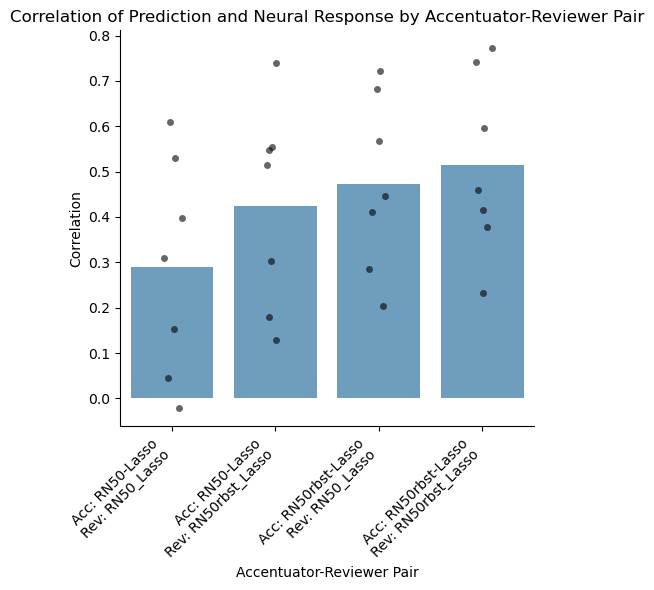

In [43]:
keys = [("resnet50-MultiLassoCV", "RN50_Lasso"), ("resnet50-MultiLassoCV", "RN50rbst_Lasso"), ("robust_resnet50-MultiLassoCV", "RN50_Lasso"), ("robust_resnet50-MultiLassoCV", "RN50rbst_Lasso")]
abbr_keys = [("RN50-Lasso", "RN50_Lasso"), ("RN50-Lasso", "RN50rbst_Lasso"), ("RN50rbst-Lasso", "RN50_Lasso"), ("RN50rbst-Lasso", "RN50rbst_Lasso")]
# Prepare data for plotting
data_for_df = []
for key, abbr_key in zip(keys, abbr_keys):
    vals = [df.loc[key[0], key[1]] for df in corr_df_col]
    for val in vals:
        data_for_df.append({
            'Accentuator-Reviewer Pair': f"Acc: {abbr_key[0]}\nRev: {abbr_key[1]}",
            'Correlation': val
        })

# Create DataFrame for seaborn
plot_df = pd.DataFrame(data_for_df)
# Create a figure for the bar plot
plt.figure(figsize=(5, 6))
# Use seaborn's barplot with individual points
ax = sns.barplot(x='Accentuator-Reviewer Pair', y='Correlation', data=plot_df, 
                 estimator=np.mean, errorbar=None, alpha=0.7)
# Add individual data points with jitter
sns.stripplot(x='Accentuator-Reviewer Pair', y='Correlation', data=plot_df,
              color='black', alpha=0.6, size=5, jitter=True)

# Add title and adjust layout
plt.title('Correlation of Prediction and Neural Response by Accentuator-Reviewer Pair')
plt.xticks(rotation=45, ha='right')
saveallforms(figoutdir, f"correlation_of_prediction_and_neural_response_summary_LassoModel_peer_review")
plt.tight_layout()

In [ ]:
corr_df.loc["resnet50-RidgeCV", "RN50_Ridge"]

RN50_Ridge  RN50_Lasso  RN50rbst_Ridge  \
resnet50-RidgeCV                0.182141    0.258580        0.268832   
resnet50-MultiLassoCV           0.116765    0.151993        0.315614   
robust_resnet50-RidgeCV         0.601203    0.550418        0.691098   
robust_resnet50-MultiLassoCV    0.416902    0.411440        0.416905   
All_acc_unit                    0.296004    0.310965        0.469096   
NSD                             0.550387    0.507775        0.518435   
controversial                  -0.257634   -0.250735        0.269644   
All                             0.227313    0.246125        0.430819   

                              RN50rbst_Lasso  
resnet50-RidgeCV                    0.291749  
resnet50-MultiLassoCV               0.303369  
robust_resnet50-RidgeCV             0.672216  
robust_resnet50-MultiLassoCV        0.416323  
All_acc_unit                        0.454951  
NSD                                 0.453878  
controversial                       0.278391  
All                                 0.423213

In [166]:
neural_resp = ds3.neural_response.isel(stimulus=stim_index, unit=target_unit_id)

In [167]:
neural_resp

<xarray.DataArray 'neural_response' (stimulus: 3420)> Size: 14kB
[3420 values with dtype=float32]
Coordinates:
  * stimulus    (stimulus) <U107 1MB 'controversial_max_r50_MultiLassoCV_unit...
    image_path  (stimulus) <U184 3MB ...
    unit        int64 8B 9

In [168]:
target_unit_id

9

In [200]:
stim_contrv_meta_df.query('is_controversial and model == "robust"')

stimulus  accentuated   model  \
70   controversial_max_robust_MultiLassoCV_unit_15_...        False  robust   
71   controversial_max_robust_MultiLassoCV_unit_15_...        False  robust   
72   controversial_max_robust_MultiLassoCV_unit_15_...        False  robust   
73   controversial_max_robust_MultiLassoCV_unit_15_...        False  robust   
74   controversial_max_robust_MultiLassoCV_unit_15_...        False  robust   
..                                                 ...          ...     ...   
135  controversial_max_robust_MultiLassoCV_unit_9_i...        False  robust   
136  controversial_max_robust_MultiLassoCV_unit_9_i...        False  robust   
137  controversial_max_robust_MultiLassoCV_unit_9_i...        False  robust   
138  controversial_max_robust_MultiLassoCV_unit_9_i...        False  robust   
139  controversial_max_robust_MultiLassoCV_unit_9_i...        False  robust   

           method  unit  img  level  score  is_nsd  is_controversial  \
70   MultiLassoCV    15    0    NaN    NaN   False              True   
71   MultiLassoCV    15    1    NaN    NaN   False              True   
72   MultiLassoCV    15    2    NaN    NaN   False              True   
73   MultiLassoCV    15    3    NaN    NaN   False              True   
74   MultiLassoCV    15    4    NaN    NaN   False              True   
..            ...   ...  ...    ...    ...     ...               ...   
135  MultiLassoCV     9    5    NaN    NaN   False              True   
136  MultiLassoCV     9    6    NaN    NaN   False              True   
137  MultiLassoCV     9    7    NaN    NaN   False              True   
138  MultiLassoCV     9    8    NaN    NaN   False              True   
139  MultiLassoCV     9    9    NaN    NaN   False              True   

     score_robust  score_r50  
70       3.709012  -4.036729  
71       4.589520  -3.880385  
72       3.785288  -4.408906  
73       3.250827  -4.101734  
74       4.091731  -3.544872  
..            ...        ...  
135      7.210146  -6.689741  
136      6.248375  -7.551818  
137      8.703208  -6.569651  
138      9.503622  -6.913553  
139      4.949420  -3.300142  

[70 rows x 12 columns]

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

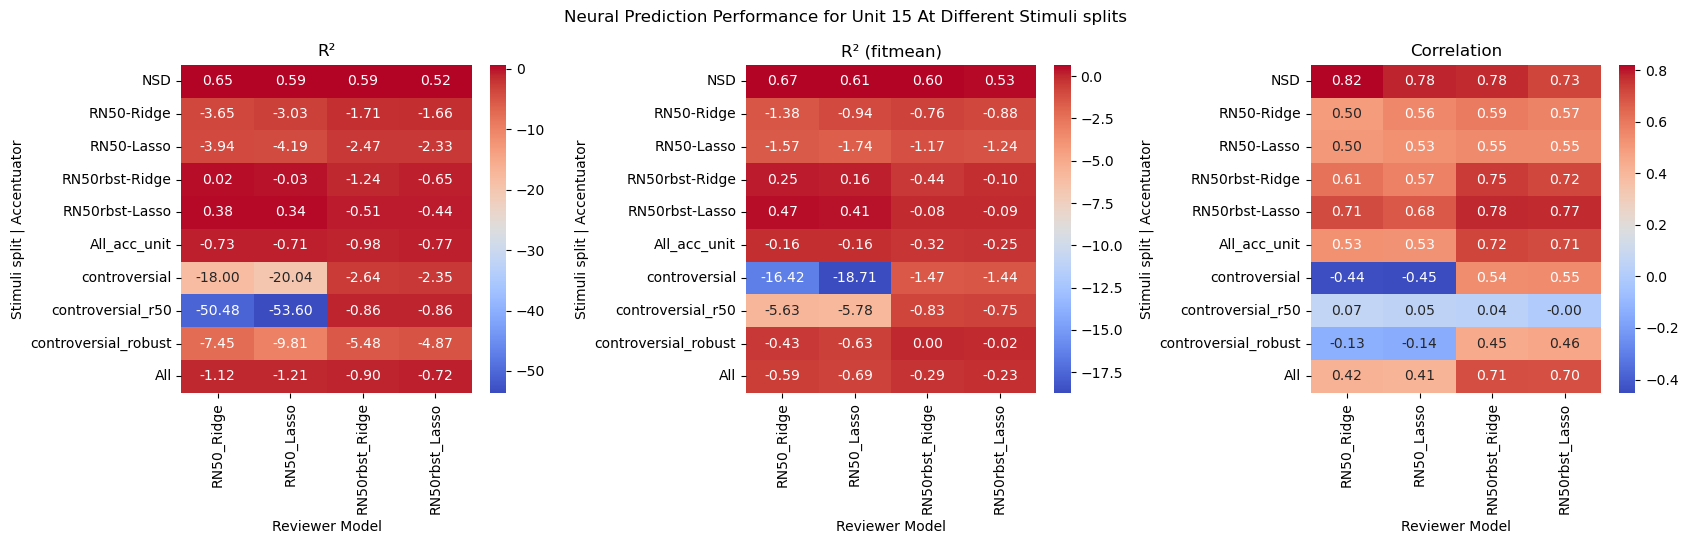

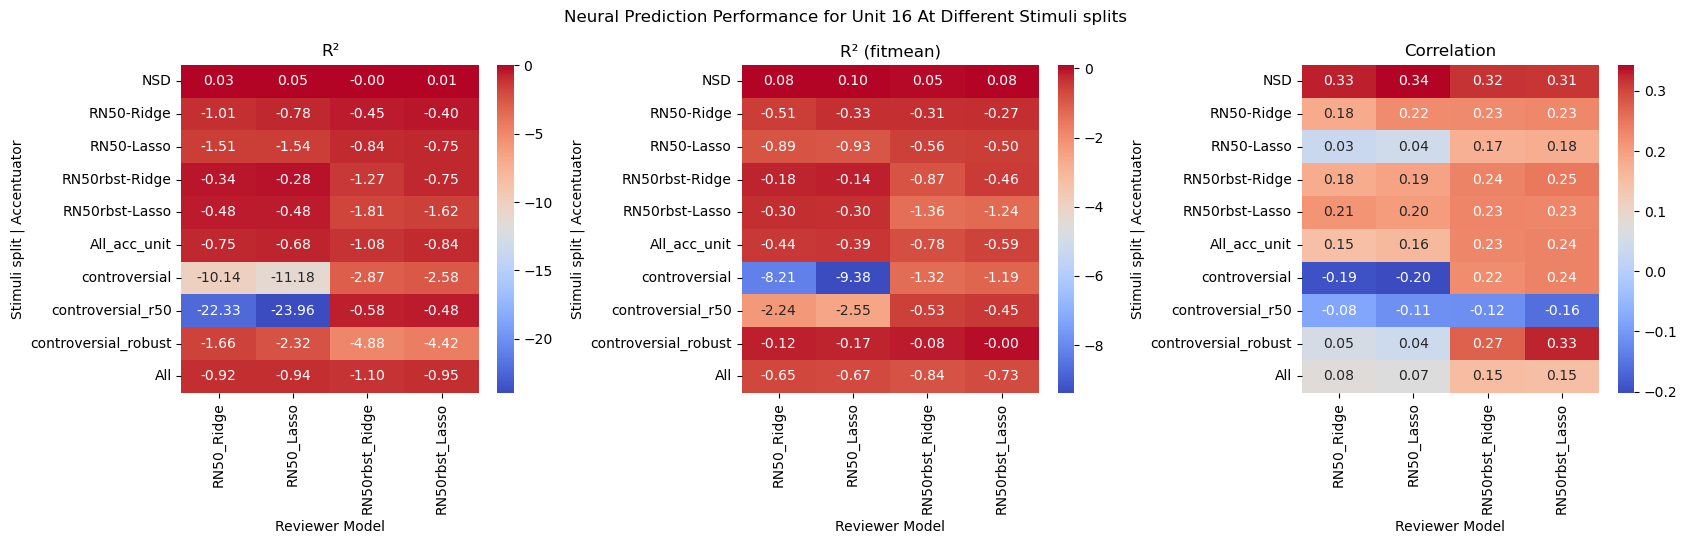

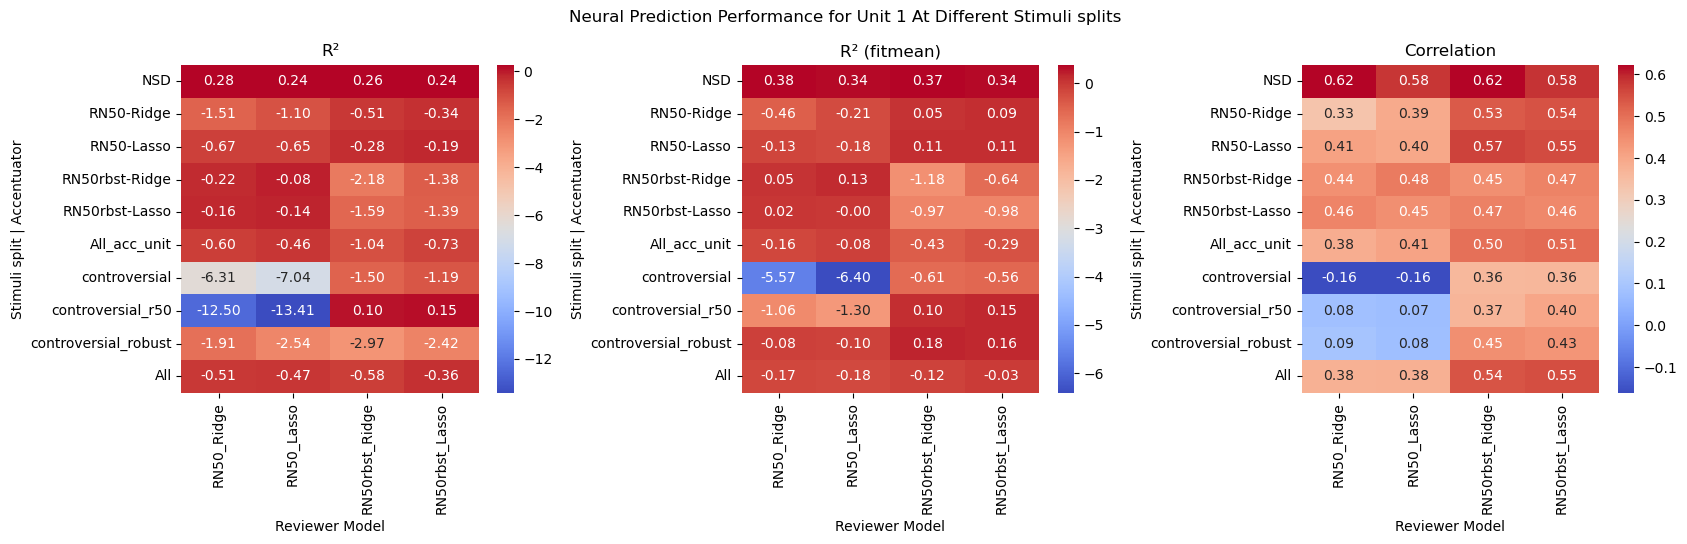

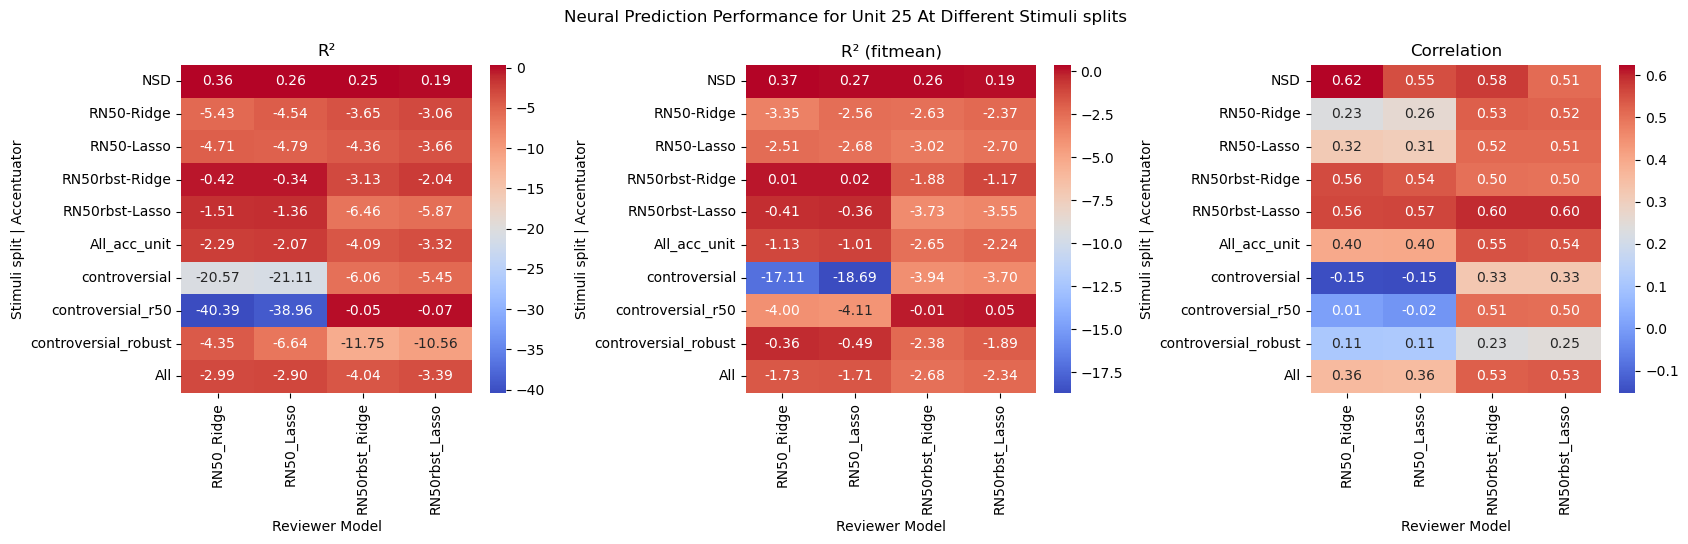

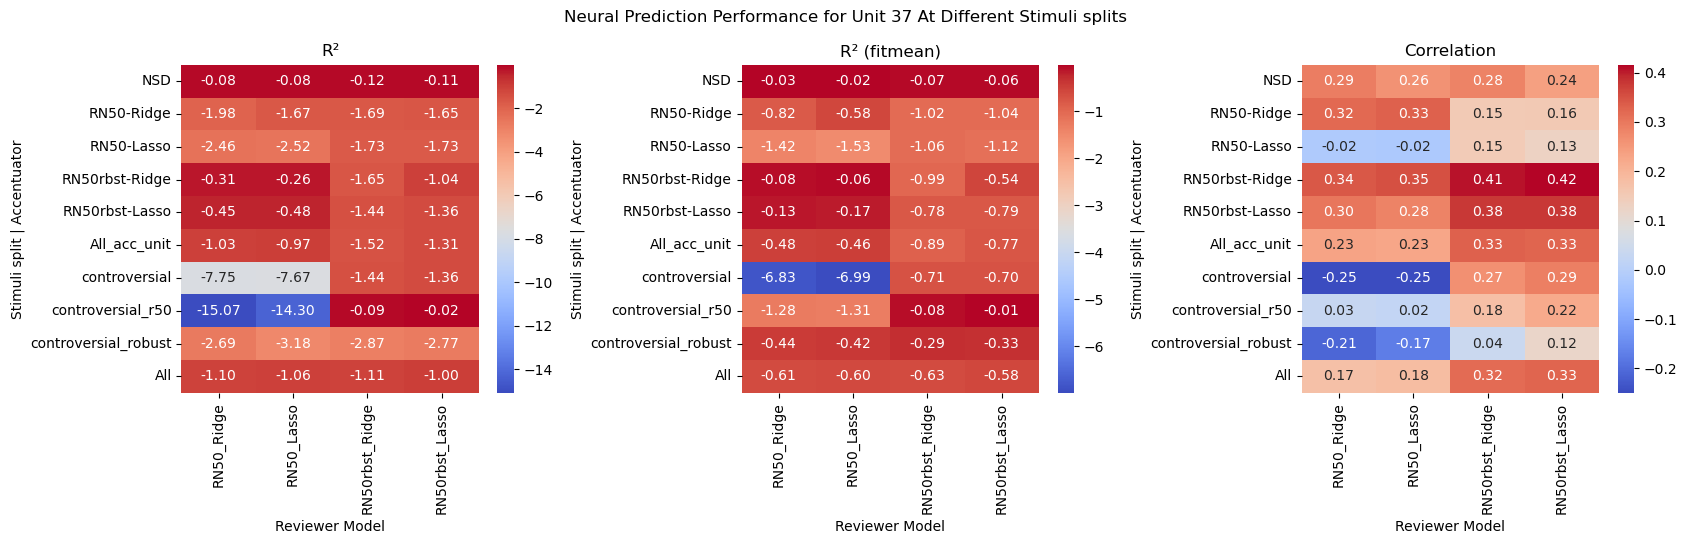

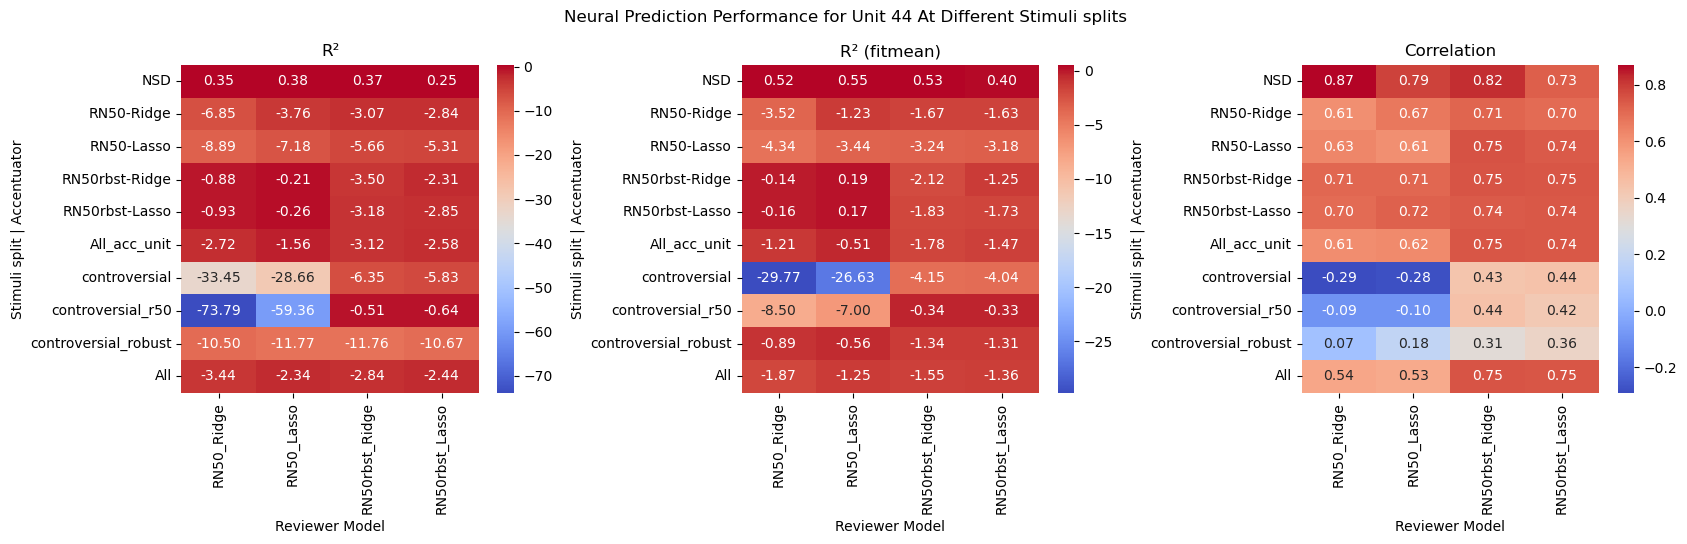

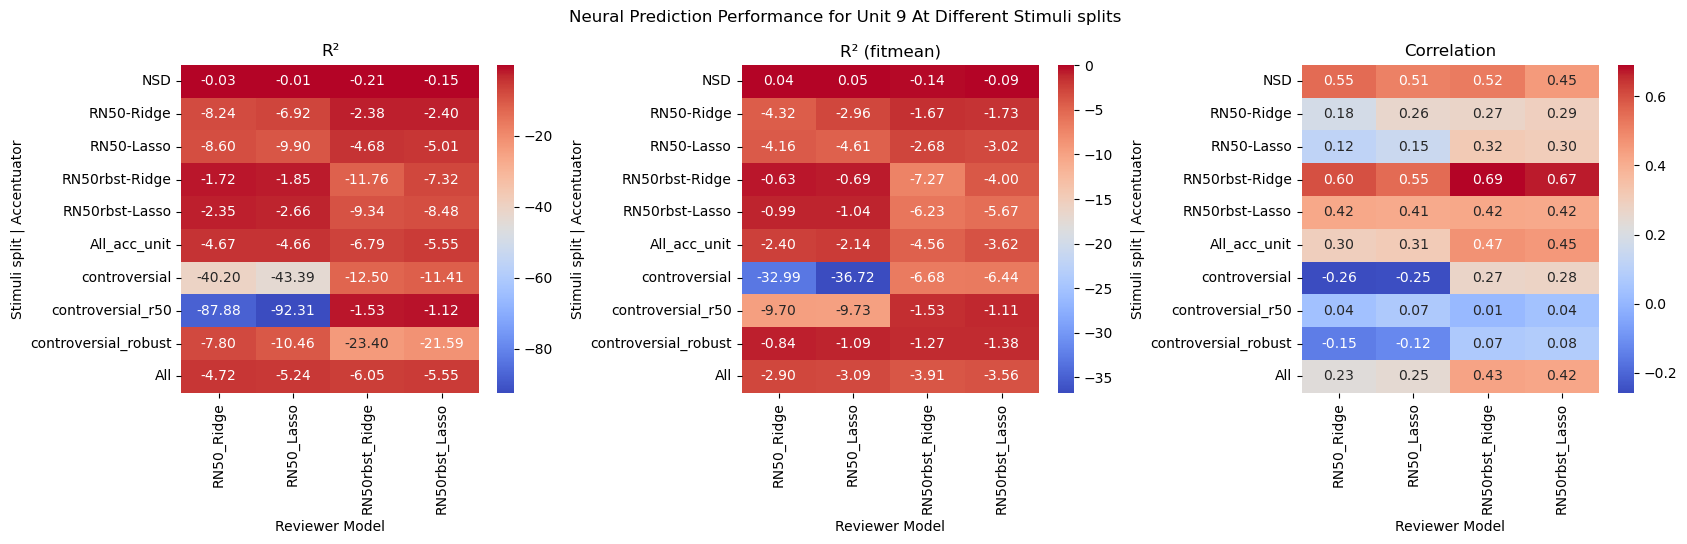

In [209]:
# Define your models and methods.
accentuator_models = ["resnet50", "robust_resnet50"]
methods = ["RidgeCV", "MultiLassoCV"]
reviewer_methods = ["RN50_Ridge", "RN50_Lasso", "RN50rbst_Ridge", "RN50rbst_Lasso"]
shorten_func = lambda x: x.replace('robust_resnet50-', 'RN50rbst-').replace('resnet50-', 'RN50-').replace('RidgeCV', 'Ridge').replace('MultiLassoCV', 'Lasso')
# target_unit_id = 16
for target_unit_id in stim_contrv_meta_df.unit.unique():
    if pd.isna(target_unit_id):
        continue
    
    stimuli_splits = {}
    stimuli_splits["NSD"] = stim_contrv_meta_df.query('is_nsd')
    for accentuator_model in accentuator_models:
        for method in methods:
            stimuli_splits[f"{accentuator_model}-{method}"] = \
                stim_contrv_meta_df.query('accentuated and model == @accentuator_model and method == @method and unit == @target_unit_id')
    stimuli_splits["All_acc_unit"] = stim_contrv_meta_df.query('accentuated and unit == @target_unit_id')
    stimuli_splits["controversial"] = stim_contrv_meta_df.query('is_controversial')
    stimuli_splits["controversial_r50"] = stim_contrv_meta_df.query('is_controversial and model == "r50"')
    stimuli_splits["controversial_robust"] = stim_contrv_meta_df.query('is_controversial and model == "robust"')
    stimuli_splits["All"] = stim_contrv_meta_df
    
    # Create row labels (e.g., "resnet50-RidgeCV")
    row_labels = list(stimuli_splits.keys());
    # Initialize DataFrames to store R2 and correlation values.
    R2_df = pd.DataFrame(index=row_labels, columns=reviewer_methods)
    corr_df = pd.DataFrame(index=row_labels, columns=reviewer_methods)
    R2_fitmean_df = pd.DataFrame(index=row_labels, columns=reviewer_methods)

    for split_name, split_df in stimuli_splits.items():
        stim_index = split_df.index
        # Loop over each reviewer method and compute R2 and correlation.
        ds3_sub = ds3.isel(stimulus=stim_index, unit=target_unit_id)
        for reviewer_model_method in reviewer_methods:
            # Use xarray dataset selection to get data for specific stimulus indices and unit
            neural_resp = ds3_sub.neural_response
            model_resp = ds3_sub[reviewer_model_method] 
            
            R2 = compute_R2_per_unit(neural_resp, model_resp)
            R2_fitmean = compute_R2_per_unit_fitmean(neural_resp, model_resp) 
            corr = compute_corr_per_unit(neural_resp, model_resp)
            R2_df.loc[split_name, reviewer_model_method] = R2.item()
            R2_fitmean_df.loc[split_name, reviewer_model_method] = R2_fitmean.item()
            corr_df.loc[split_name, reviewer_model_method] = corr.item()

    # Convert values to float for proper plotting.
    R2_df = R2_df.astype(float)
    R2_fitmean_df = R2_fitmean_df.astype(float)
    corr_df = corr_df.astype(float)

    # Plot heatmaps for R2 and correlation.
    fig, axes = plt.subplots(1, 3, figsize=(17, 5.5))
    sns.heatmap(R2_df, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0], 
                yticklabels=[shorten_func(l) for l in R2_df.index])
    axes[0].set_title("R²")
    axes[0].set_xlabel("Reviewer Model")
    axes[0].set_ylabel("Stimuli split | Accentuator")
    sns.heatmap(R2_fitmean_df, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1], 
                yticklabels=[shorten_func(l) for l in R2_fitmean_df.index])
    axes[1].set_title("R² (fitmean)")
    axes[1].set_xlabel("Reviewer Model")
    axes[1].set_ylabel("Stimuli split | Accentuator")
    sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[2], 
                yticklabels=[shorten_func(l) for l in corr_df.index])
    axes[2].set_title("Correlation")
    axes[2].set_xlabel("Reviewer Model")
    axes[2].set_ylabel("Stimuli split | Accentuator")
    plt.suptitle(f"Neural Prediction Performance for Unit {target_unit_id} At Different Stimuli splits")
    plt.tight_layout()
    plt.show()

### Per image seed evaluation

In [204]:
split_df.query('img == @img')

stimulus  accentuated     model  \
910  resnet50_RidgeCV_unit_15_img_0_level_-0.371031...         True  resnet50   
911  resnet50_RidgeCV_unit_15_img_0_level_-1.109543...         True  resnet50   
912  resnet50_RidgeCV_unit_15_img_0_level_-1.848056...         True  resnet50   
913  resnet50_RidgeCV_unit_15_img_0_level_0.3674806...         True  resnet50   
914  resnet50_RidgeCV_unit_15_img_0_level_1.1059929...         True  resnet50   
915  resnet50_RidgeCV_unit_15_img_0_level_1.8445052...         True  resnet50   
916  resnet50_RidgeCV_unit_15_img_0_level_2.5830175...         True  resnet50   
917  resnet50_RidgeCV_unit_15_img_0_level_3.3215298...         True  resnet50   
918  resnet50_RidgeCV_unit_15_img_0_level_4.0600421...         True  resnet50   
919  resnet50_RidgeCV_unit_15_img_0_level_4.7985544...         True  resnet50   
920  resnet50_RidgeCV_unit_15_img_0_level_5.5370666...         True  resnet50   

      method  unit  img     level     score  is_nsd  is_controversial  \
910  RidgeCV    15    0 -0.371032 -0.362103   False             False   
911  RidgeCV    15    0 -1.109544 -1.099940   False             False   
912  RidgeCV    15    0 -1.848056 -1.841415   False             False   
913  RidgeCV    15    0  0.367481  0.363641   False             False   
914  RidgeCV    15    0  1.105993  1.100180   False             False   
915  RidgeCV    15    0  1.844505  1.838582   False             False   
916  RidgeCV    15    0  2.583018  2.578741   False             False   
917  RidgeCV    15    0  3.321530  3.313641   False             False   
918  RidgeCV    15    0  4.060042  4.051651   False             False   
919  RidgeCV    15    0  4.798554  4.796301   False             False   
920  RidgeCV    15    0  5.537067  5.530669   False             False   

     score_robust  score_r50  
910           NaN        NaN  
911           NaN        NaN  
912           NaN        NaN  
913           NaN        NaN  
914           NaN        NaN  
915           NaN        NaN  
916           NaN        NaN  
917           NaN        NaN  
918           NaN        NaN  
919           NaN        NaN  
920           NaN        NaN

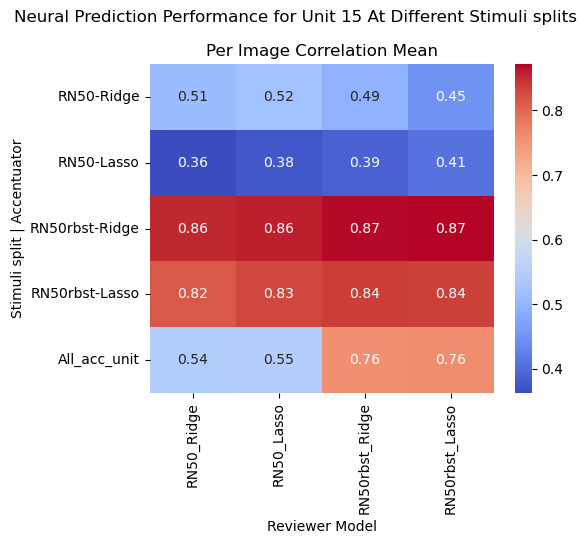

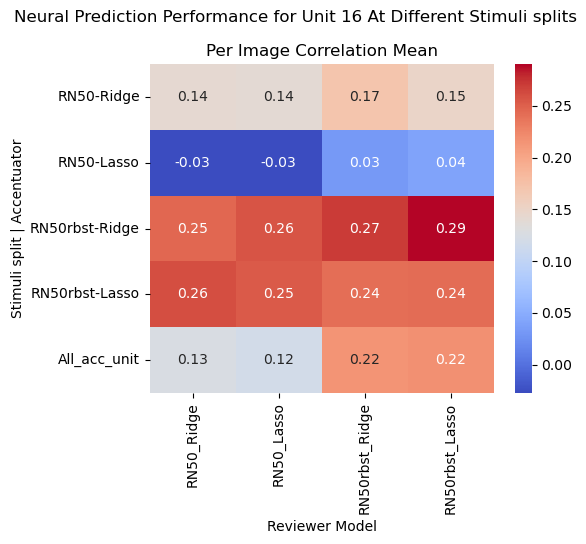

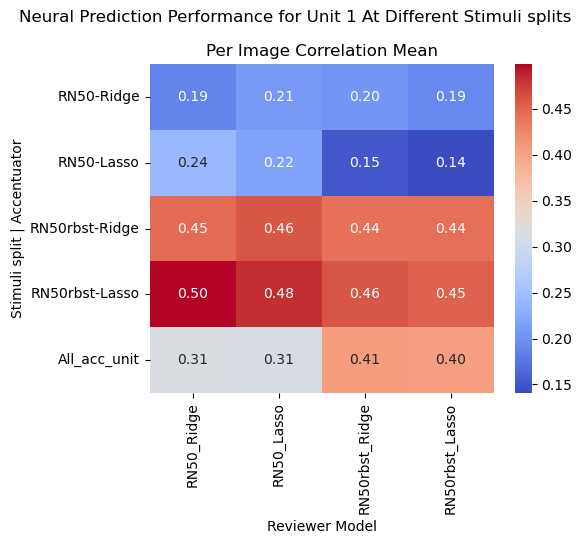

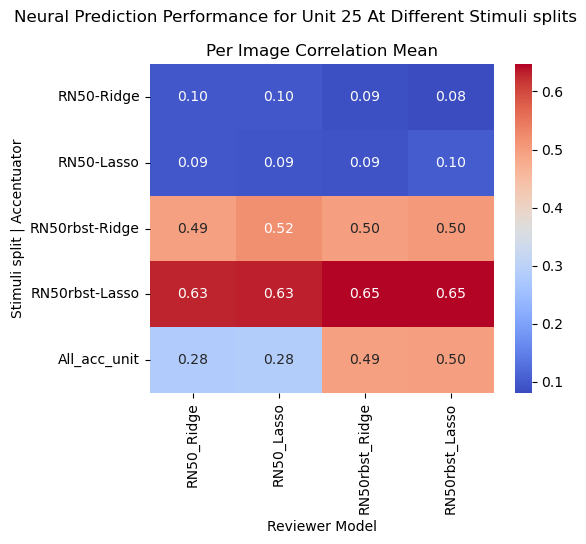

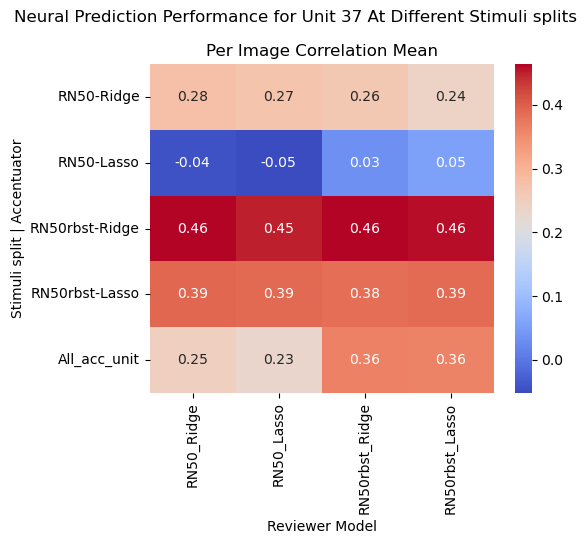

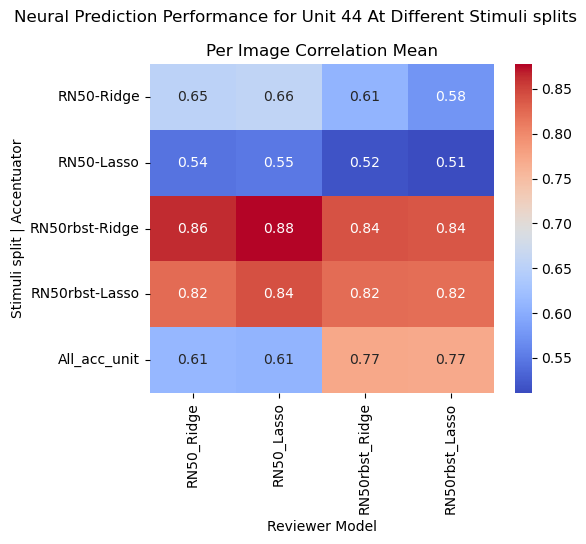

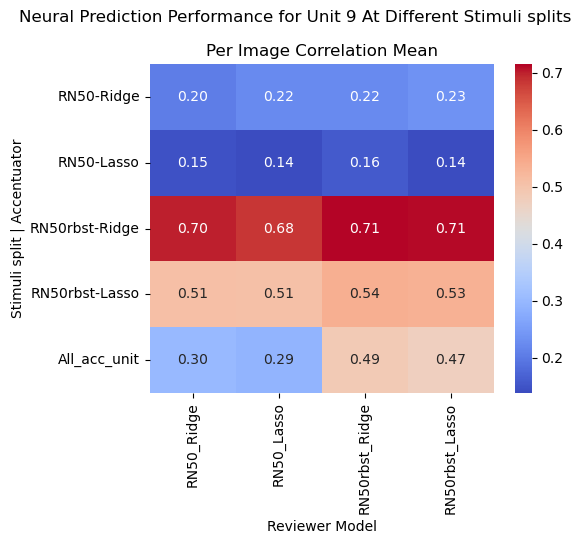

In [208]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define your models and methods.
accentuator_models = ["resnet50", "robust_resnet50"]
methods = ["RidgeCV", "MultiLassoCV"]
reviewer_methods = ["RN50_Ridge", "RN50_Lasso", "RN50rbst_Ridge", "RN50rbst_Lasso"]
shorten_func = lambda x: x.replace('robust_resnet50-', 'RN50rbst-').replace('resnet50-', 'RN50-').replace('RidgeCV', 'Ridge').replace('MultiLassoCV', 'Lasso')
target_unit_id = 16
for target_unit_id in stim_contrv_meta_df.unit.unique():
    if pd.isna(target_unit_id):
        continue
    stimuli_splits = {}
    # stimuli_splits["NSD"] = stim_contrv_meta_df.query('is_nsd')
    for accentuator_model in accentuator_models:
        for method in methods:
            stimuli_splits[f"{accentuator_model}-{method}"] = \
                stim_contrv_meta_df.query('accentuated and model == @accentuator_model and method == @method and unit == @target_unit_id')
    stimuli_splits["All_acc_unit"] = stim_contrv_meta_df.query('accentuated and unit == @target_unit_id')
    # stimuli_splits["controversial"] = stim_contrv_meta_df.query('is_controversial')
    # stimuli_splits["controversial_r50"] = stim_contrv_meta_df.query('is_controversial and model == "r50"')
    # stimuli_splits["controversial_robust"] = stim_contrv_meta_df.query('is_controversial and model == "robust"')
    # stimuli_splits["All"] = stim_contrv_meta_df
    
    # Create row labels (e.g., "resnet50-RidgeCV")
    row_labels = list(stimuli_splits.keys());
    # Initialize DataFrames to store R2 and correlation values.
    # R2_df = pd.DataFrame(index=row_labels, columns=reviewer_methods)
    per_img_corr_df = pd.DataFrame(index=row_labels, columns=reviewer_methods)
    # R2_fitmean_df = pd.DataFrame(index=row_labels, columns=reviewer_methods)

    for split_name, split_df in stimuli_splits.items():
        stim_index = split_df.index
        # Loop over each reviewer method and compute R2 and correlation.
        # ds3_sub = ds3.isel(stimulus=stim_index, unit=target_unit_id)
        for reviewer_model_method in reviewer_methods:
            # Use xarray dataset selection to get data for specific stimulus indices and unit
            # neural_resp = ds3_sub.neural_response
            # model_resp = ds3_sub[reviewer_model_method] 
            corr_per_img = []
            for img in split_df.img.unique():
                img_index = split_df.query('img == @img').index
                neural_resp_img = ds3.neural_response.isel(stimulus=img_index, unit=target_unit_id)
                model_resp_img = ds3[reviewer_model_method].isel(stimulus=img_index, unit=target_unit_id)
                corr = compute_corr_per_unit(neural_resp_img, model_resp_img)
                corr_per_img.append(corr.item())
            per_img_corr_df.loc[split_name, reviewer_model_method] = np.mean(corr_per_img)
            
            # R2 = compute_R2_per_unit(neural_resp, model_resp)
            # R2_fitmean = compute_R2_per_unit_fitmean(neural_resp, model_resp) 
            # corr = compute_corr_per_unit(neural_resp, model_resp)
            # # R2_df.loc[split_name, reviewer_model_method] = R2.item()
            # # R2_fitmean_df.loc[split_name, reviewer_model_method] = R2_fitmean.item()
            # per_img_corr_df.loc[split_name, reviewer_model_method] = corr.item()

    # Convert values to float for proper plotting.
    # R2_df = R2_df.astype(float)
    # R2_fitmean_df = R2_fitmean_df.astype(float)
    per_img_corr_df = per_img_corr_df.astype(float)
    # Plot heatmaps for R2 and correlation.
    fig, axes = plt.subplots(1, 1, figsize=(6, 5.5))
    sns.heatmap(per_img_corr_df, annot=True, fmt=".2f", cmap="coolwarm", ax=axes, 
                yticklabels=[shorten_func(l) for l in per_img_corr_df.index])
    axes.set_title("Per Image Correlation Mean")
    axes.set_xlabel("Reviewer Model")
    axes.set_ylabel("Stimuli split | Accentuator")
    # sns.heatmap(R2_fitmean_df, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1], 
    #             yticklabels=[shorten_func(l) for l in R2_fitmean_df.index])
    # axes[1].set_title("R² per Unit (fitmean)")
    # axes[1].set_xlabel("Reviewer Model")
    # axes[1].set_ylabel("Stimuli split | Accentuator")
    # sns.heatmap(per_img_corr_df, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[2], 
    #             yticklabels=[shorten_func(l) for l in corr_df.index])
    # axes[2].set_title("Correlation per Unit")
    # axes[2].set_xlabel("Reviewer Model")
    # axes[2].set_ylabel("Stimuli split | Accentuator")
    plt.suptitle(f"Neural Prediction Performance for Unit {target_unit_id} At Different Stimuli splits")
    plt.tight_layout()
    plt.show()

In [ ]:
target_unit_id = 44
accentuator_model = "resnet50"
method = "RidgeCV"
unit_acc_partdf = stim_meta_df.query('accentuated and model == @accentuator_model and method == @method and unit == @target_unit_id')
R2 = compute_R2_per_unit(ds3.neural_response[unit_acc_partdf.index, target_unit_id], ds3.RN50_Ridge[unit_acc_partdf.index, target_unit_id],)
corr = compute_corr_per_unit(ds3.neural_response[unit_acc_partdf.index, target_unit_id], ds3.RN50_Ridge[unit_acc_partdf.index, target_unit_id],)
print(R2, corr)

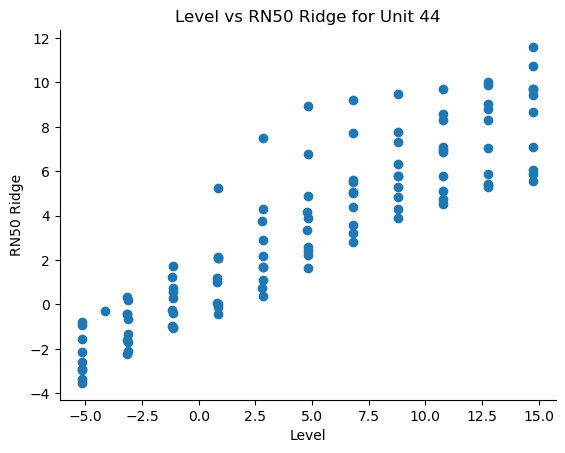

In [73]:
plt.scatter(unit_acc_partdf.score, ds3.RN50_Ridge[unit_acc_partdf.index, 44])
plt.xlabel("Level")
plt.ylabel("RN50 Ridge")
plt.title("Level vs RN50 Ridge for Unit 44")
plt.show()

In [25]:
(stimulus_d3['stimulus'].str.contains('nsd')).sum()

200

In [29]:
(stimulus_d3['stimulus'].str.contains('controversial')).sum()

140

In [28]:
stimulus_d3[~stimulus_d3['stimulus'].str.contains('controversial')]

stimulus
140   resnet50_MultiLassoCV_unit_15_img_0_level_-0.4...
141   resnet50_MultiLassoCV_unit_15_img_0_level_-1.2...
142   resnet50_MultiLassoCV_unit_15_img_0_level_-1.9...
143   resnet50_MultiLassoCV_unit_15_img_0_level_0.24...
144   resnet50_MultiLassoCV_unit_15_img_0_level_0.97...
...                                                 ...
3415                            shared0508_nsd38495.png
3416                            shared0560_nsd42215.png
3417                            shared0631_nsd46161.png
3418                            shared0862_nsd62480.png
3419                            shared0974_nsd70506.png

[3280 rows x 1 columns]

In [27]:
stimulus_d3[~stimulus_d3['stimulus'].str.contains('nsd')]

stimulus
0     controversial_max_r50_MultiLassoCV_unit_15_img...
1     controversial_max_r50_MultiLassoCV_unit_15_img...
2     controversial_max_r50_MultiLassoCV_unit_15_img...
3     controversial_max_r50_MultiLassoCV_unit_15_img...
4     controversial_max_r50_MultiLassoCV_unit_15_img...
...                                                 ...
3215  robust_resnet50_RidgeCV_unit_9_img_9_level_2.3...
3216  robust_resnet50_RidgeCV_unit_9_img_9_level_4.1...
3217  robust_resnet50_RidgeCV_unit_9_img_9_level_6.0...
3218  robust_resnet50_RidgeCV_unit_9_img_9_level_7.8...
3219  robust_resnet50_RidgeCV_unit_9_img_9_level_9.6...

[3220 rows x 1 columns]

In [ ]:
unit_id = 44
plt.scatter(ds1["RN50_Lasso"][:, unit_id], ds1["neural_response"][:, unit_id])
plt.scatter(ds3["RN50_Lasso"][:, unit_id], ds3["neural_response"][:, unit_id])
plt.xlabel("RN50 Lasso")
plt.ylabel("Neural Response")
plt.title(f"Unit {unit_id}")
plt.legend()
plt.show()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14994a833ac0>
Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/selectors.py

### Validating neuronal responses

In [26]:
list(data_dict_day3)

['brain_area',
 'ncsnr',
 'reliability',
 'stim_pos',
 'stim_size',
 'resp_mat',
 'resp_temp_mat',
 'image_fps',
 'stimulus_names']

In [28]:
data_dict_day3["resp_mat"].shape

(3420, 64)

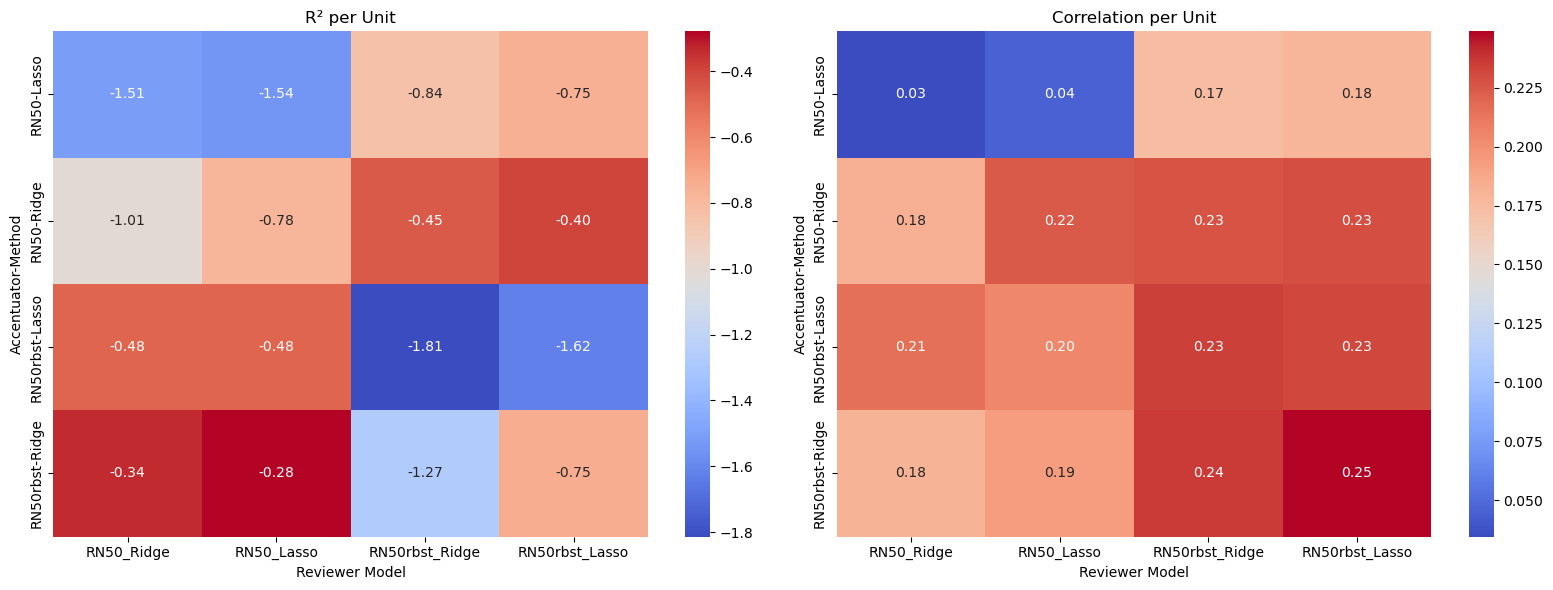

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define your models and methods.
accentuator_models = ["resnet50", "robust_resnet50"]
methods = ["RidgeCV", "MultiLassoCV"]
reviewer_methods = ["RN50_Ridge", "RN50_Lasso", "RN50rbst_Ridge", "RN50rbst_Lasso"]
target_unit_id = 16

# Create a list to store all results
results = []

# Loop over each combination and compute metrics
for accentuator_model in accentuator_models:
    for method in methods:
        # Filter stim_meta_df based on criteria
        unit_acc_partdf = stim_meta_df.query('accentuated and model == @accentuator_model and method == @method and unit == @target_unit_id')
        stim_index = unit_acc_partdf.index
        
        # Loop over each reviewer method
        for reviewer_model_method in reviewer_methods:
            R2 = compute_R2_per_unit(ds3.neural_response[stim_index, target_unit_id],
                                   ds3[reviewer_model_method][stim_index, target_unit_id])
            corr = compute_corr_per_unit(ds3.neural_response[stim_index, target_unit_id],
                                       ds3[reviewer_model_method][stim_index, target_unit_id])
            
            results.append({
                'accentuator_model': accentuator_model,
                'method': method,
                'reviewer_method': reviewer_model_method,
                'R2': R2.item(),
                'correlation': corr.item()
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Create pivot tables for R2 and correlation
R2_df = results_df.pivot_table(
    index=['accentuator_model', 'method'],
    columns='reviewer_method',
    values='R2'
).reset_index()
R2_df.index = [f"{am}-{m}" for am, m in zip(R2_df['accentuator_model'], R2_df['method'])]
R2_df = R2_df[reviewer_methods]

corr_df = results_df.pivot_table(
    index=['accentuator_model', 'method'],
    columns='reviewer_method',
    values='correlation'
).reset_index()
corr_df.index = [f"{am}-{m}" for am, m in zip(corr_df['accentuator_model'], corr_df['method'])]
corr_df = corr_df[reviewer_methods]

# Plot heatmaps for R2 and correlation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(R2_df, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0],
            yticklabels=[shorten_func(l) for l in R2_df.index])
axes[0].set_title("R² per Unit")
axes[0].set_xlabel("Reviewer Model")
axes[0].set_ylabel("Accentuator-Method")
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1],
            yticklabels=[shorten_func(l) for l in corr_df.index])
axes[1].set_title("Correlation per Unit")
axes[1].set_xlabel("Reviewer Model")
axes[1].set_ylabel("Accentuator-Method")
plt.tight_layout()
plt.show()